# Predictive Occupancy Modelling for Effective Linen Supply Management

## Background
Premier Inn, the UK's largest hotel brand, manages over 800 hotels across the country. With such a vast operation, effectively managing resources while ensuring optimal guest satisfaction is a challenging task. One of the crucial aspects of these operations is the management of linen supplies - an area where there is substantial scope for efficiency and cost savings through accurate prediction and automation.

### Objective
1) Implement a model for hotel's final occupancy prediction three days prior to our guests' scheduled arrival. 

2) Prepare a basic plan to deploy the solution across our extensive network of over 800 sites.

In [1]:
# Import Required Libraries
import os
import sys
from src.exception import CustomException
from src.logger import logging
from src.utils import *
from dataclasses import dataclass

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# Set the figure size for better visualization
plt.figure(figsize=(15, 8))

import warnings
warnings.filterwarnings('ignore')

# Modelling
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge,Lasso
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Replace 'YYYY-MM-DD' with your actual date format in the 'format' parameter
date_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y')

# Load Dataset

In [4]:
digital_visits_df = pd.read_csv('data/digital_visits.csv', parse_dates=['stay_date'], date_parser=date_parser)
digital_visits_df.head()

,stay_date,hotel_key,lead_time,bing_ppc_brand,google_ppc_brand,total_vws
0,2021-05-01,242,3,153,973,1126
1,2021-05-01,47,3,31,107,138
2,2021-05-01,221,3,25,115,140
3,2021-05-01,488,3,24,113,137
4,2021-05-01,704,3,8,69,77


In [5]:
BK_LT_0_df = pd.read_csv('data/hotel_bookings_at_leadtime_0.csv', parse_dates=['stay_date'], date_parser=date_parser)
BK_LT_0_df.head()

,hotel_key,lead_time,stay_date,finalroomssold
0,1,0,2021-05-01,36
1,1,0,2021-05-02,71
2,1,0,2021-05-03,64
3,1,0,2021-05-04,94
4,1,0,2021-05-05,96


In [6]:
BK_LT_3_df = pd.read_csv('data/hotel_bookings_at_leadtime_3.csv', parse_dates=['stay_date'], date_parser=date_parser)
BK_LT_3_df.head()

,hotel_key,stay_date,lead_time,off_rooms,sellable_capacity,total_rooms_sold,rooms_remaining,flex_rate,saver_rate,semi_flex_rate
0,488,2021-05-30,3,4,62,64,-2,NaN,NaN,NaN
1,111,2021-05-29,3,0,60,60,0,NaN,NaN,NaN
2,634,2021-05-29,3,0,20,20,0,NaN,NaN,NaN
3,917,2021-05-27,3,1,105,17,88,35.0,0.0,0.0
4,554,2021-05-25,3,0,42,20,22,57.0,0.0,0.0


In [7]:
BK_LT_3_reserv_ch_df = pd.read_csv('data/hotel_bookings_at_leadtime_3_by_reservation_channel.csv', parse_dates=['stay_date'], date_parser=date_parser)
BK_LT_3_reserv_ch_df.head()

,hotel_key,lead_time,stay_date,total_rooms_sold,avgnights,totaladults,totalchildren,totalgrossrevenue_room,totalnetrevenue_breakfast,totalnetrevenue_mealdeal,...,corporate_booking_tool,front_desk,ccc,travelport_gds,agency,germany_web_de,amadeus_gds,hub_mobile_app,mobile_web,booking_com
0,704,3,2021-05-01,6,1,10,5,186.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,221,3,2021-05-01,11,3,14,3,381.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,765,3,2021-05-01,60,2,97,7,2693.0,0.0,0.0,...,4,14,14,1,0,0,0,0,0,0
3,47,3,2021-05-01,32,4,46,7,1145.0,0.0,0.0,...,4,0,0,0,0,0,0,0,0,0
4,826,3,2021-05-01,23,2,35,2,780.5,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
Canc_LT_3_df = pd.read_csv('data/recent_cancellations_at_leadtime_3.csv', parse_dates=['stay_date'], date_parser=date_parser)
Canc_LT_3_df.head()

,hotel_key,stay_date,Canxrooms_last7days
0,1,2021-05-03,-2
1,1,2021-05-17,-3
2,1,2021-05-26,-1
3,1,2021-05-05,-2
4,1,2021-05-16,-4


In [9]:
hotel_details_df = pd.read_csv('data/hotel_details.csv')
hotel_details_df.head()

,hotel_key,hotel_name,trading_area,family_rooms,air_conditioned_rooms,london_region_split,brand
0,10,Alderley Edge,Not Trading 3,0.0,NaN,Other,Premier Inn
1,1,Aberdeen Airport (Dyce),Scotland North,86.0,All rooms have air con.,Regions,Premier Inn
2,86,Braintree (Freeport Village),Essex,2.0,No Air Con,Regions,Premier Inn
3,106,Bristol Sidcot (A38),Bristol/Somerset,4.0,All areas air conditioned,Regions,Premier Inn
4,35,Barnsley Central M1 J37,Yorkshire,32.0,All rooms have air con.,Regions,Premier Inn


# EDA

In [10]:
# size of relevant datasets
print("digital_visits shape:", digital_visits_df.shape)
print("hotel_details shape:", hotel_details_df.shape)
print("hotel_bookings_at_leadtime_3_by_reservation_channel shape:", BK_LT_3_reserv_ch_df.shape)
print("recent_cancellations_at_leadtime_3 shape:", Canc_LT_3_df.shape)
print("bookings_leadtime_0_df shape:", BK_LT_0_df.shape)
print("bookings_leadtime_3_df shape:", BK_LT_3_df.shape)

digital_visits shape: (26389, 6)
hotel_details shape: (983, 7)
hotel_bookings_at_leadtime_3_by_reservation_channel shape: (24646, 23)
recent_cancellations_at_leadtime_3 shape: (14613, 3)
bookings_leadtime_0_df shape: (24534, 4)
bookings_leadtime_3_df shape: (24602, 10)


In [11]:
# Check for duplicate data
print("Duplicate Data Summary:")
print("digital_visits :", digital_visits_df.duplicated().sum())
print("hotel_details :", hotel_details_df.duplicated().sum())
print("hotel_bookings_at_leadtime_3_by_reservation_channel :", BK_LT_3_reserv_ch_df.duplicated().sum())
print("recent_cancellations_at_leadtime_3 :", Canc_LT_3_df.duplicated().sum())
print("bookings_leadtime_0_df :", BK_LT_0_df.duplicated().sum())
print("bookings_leadtime_3_df :", BK_LT_3_df.duplicated().sum())

Duplicate Data Summary:
digital_visits : 0
hotel_details : 0
hotel_bookings_at_leadtime_3_by_reservation_channel : 0
recent_cancellations_at_leadtime_3 : 0
bookings_leadtime_0_df : 0
bookings_leadtime_3_df : 0


In [12]:
# feature set for relevant datasets
print("digital_visits features:\n", digital_visits_df.columns,"\n")
print("hotel_details features:\n", hotel_details_df.columns,"\n")
print("hotel_bookings_at_leadtime_3_by_reservation_channel features:\n", BK_LT_3_reserv_ch_df.columns,"\n")
print("recent_cancellations_at_leadtime_3 features:\n", Canc_LT_3_df.columns,"\n")
print("bookings_leadtime_0_df features:\n", BK_LT_0_df.columns,"\n")
print("bookings_leadtime_3_df features:\n", BK_LT_3_df.columns,"\n")

digital_visits features:
 Index(['stay_date', 'hotel_key', 'lead_time', 'bing_ppc_brand',
       'google_ppc_brand', 'total_vws'],
      dtype='object') 

hotel_details features:
 Index(['hotel_key', 'hotel_name', 'trading_area', 'family_rooms',
       'air_conditioned_rooms', 'london_region_split', 'brand'],
      dtype='object') 

hotel_bookings_at_leadtime_3_by_reservation_channel features:
 Index(['hotel_key', 'lead_time', 'stay_date', 'total_rooms_sold', 'avgnights',
       'totaladults', 'totalchildren', 'totalgrossrevenue_room',
       'totalnetrevenue_breakfast', 'totalnetrevenue_mealdeal',
       'totalnetrevenue_room', 'mobile_app', 'web_2014',
       'corporate_booking_tool', 'front_desk', 'ccc', 'travelport_gds',
       'agency', 'germany_web_de', 'amadeus_gds', 'hub_mobile_app',
       'mobile_web', 'booking_com'],
      dtype='object') 

recent_cancellations_at_leadtime_3 features:
 Index(['hotel_key', 'stay_date', 'Canxrooms_last7days'], dtype='object') 

bookings_leadti

In [13]:
# Check data info
print("Data Information:")

print("\ndigital_visits :", digital_visits_df.info())
print("\nhotel_details :", hotel_details_df.info())
print("\nhotel_bookings_at_leadtime_3_by_reservation_channel :", BK_LT_3_reserv_ch_df.info())
print("\nrecent_cancellations_at_leadtime_3 :", Canc_LT_3_df.info())
print("\nbookings_leadtime_0_df :", BK_LT_0_df.info())
print("\nbookings_leadtime_3_df :", BK_LT_3_df.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26389 entries, 0 to 26388
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   stay_date         26389 non-null  datetime64[ns]
 1   hotel_key         26389 non-null  int64         
 2   lead_time         26389 non-null  int64         
 3   bing_ppc_brand    26389 non-null  int64         
 4   google_ppc_brand  26389 non-null  int64         
 5   total_vws         26389 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.2 MB

digital_visits : None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_key              983 non-null    int64  
 1   hotel_name             983 non-null    object 
 2   trading_area           980 non-null    object

In [14]:
# Check for missing data
print("Missing Data Summary:")
print("\ndigital_visits :", digital_visits_df.isnull().sum())
print("\nhotel_details :", hotel_details_df.isnull().sum())
print("\nhotel_bookings_at_leadtime_3_by_reservation_channel :", BK_LT_3_reserv_ch_df.isnull().sum())
print("\nrecent_cancellations_at_leadtime_3 :", Canc_LT_3_df.isnull().sum())
print("\nbookings_leadtime_0_df :", BK_LT_0_df.isnull().sum())
print("\nbookings_leadtime_3_df :", BK_LT_3_df.isnull().sum())

Missing Data Summary:

digital_visits : stay_date           0
hotel_key           0
lead_time           0
bing_ppc_brand      0
google_ppc_brand    0
total_vws           0
dtype: int64

hotel_details : hotel_key                  0
hotel_name                 0
trading_area               3
family_rooms               4
air_conditioned_rooms    133
london_region_split       34
brand                      0
dtype: int64

hotel_bookings_at_leadtime_3_by_reservation_channel : hotel_key                    0
lead_time                    0
stay_date                    0
total_rooms_sold             0
avgnights                    0
totaladults                  0
totalchildren                0
totalgrossrevenue_room       0
totalnetrevenue_breakfast    0
totalnetrevenue_mealdeal     0
totalnetrevenue_room         0
mobile_app                   0
web_2014                     0
corporate_booking_tool       0
front_desk                   0
ccc                          0
travelport_gds               0


In [15]:
### Merge relevant datasets ###
"""
- digital_visits.csv – This file provides details of digital demand for each site 3 days before the stay date.
- hotel_details.csv – Includes details of hotels
- hotel_bookings_at_leadtime_3_by_reservation_channel.csv – This file includes aggregate measures for every hotel 
                                                            and staydate 3 days before guests are expected to arrive. 
                                                            The aggregate measures are further broken down by reservation 
                                                            channels. 
- recent_cancellations_at_leadtime_3.csv – This file provides details cancellations by site for each stay date,
                                            3 days before guests arrive. 
- hotel_bookings_at_leadtime_0.csv – This file provides details of total rooms sold outcome by site and stay date.
- hotel_bookings_at_leadtime_3.csv – This file includes aggregate measures such as rooms sold, off room (Rooms that were
                                    not available to be sold e.g., refurbishments, maintenance etc), average price information
                                    for flex, saver and semi-flex room products.

"""
# 'hotel_key' is common keys to merge the digital_visits and hotel_details datasets
data = pd.merge(digital_visits_df, hotel_details_df,on='hotel_key', how='left')

# 'hotel_key', 'stay_date','lead_time','total_rooms_sold' are common keys to merge the datasets
data = pd.merge(data, BK_LT_3_reserv_ch_df, on=['hotel_key', 'stay_date','lead_time'], how='left')

# 'hotel_key', 'stay_date' are common keys to merge the datasets
data = pd.merge(data, Canc_LT_3_df, on=['hotel_key', 'stay_date'], how='left')

# 'hotel_key', 'stay_date','lead_time' are common keys to merge the datasets
data = pd.merge(data, BK_LT_0_df, on=['hotel_key', 'stay_date','lead_time'], how='left')
data = pd.merge(data, BK_LT_3_df, on=['hotel_key', 'stay_date','lead_time','total_rooms_sold'], how='left')


In [16]:
# drop hotel_key and hotel_name because of identifier
data = data.drop(['hotel_key','hotel_name'],axis=1)

In [17]:
# size of relevant datasets
print("shape:", data.shape)

shape: (26389, 38)


In [18]:
# Check for duplicate data
print("duplicate data :", data.duplicated().sum())

duplicate data : 39


In [19]:
# handle duplicate data
data = data.drop_duplicates()

In [20]:
# feature set for relevant datasets
print("data features:\n", data.columns,"\n")

data features:
 Index(['stay_date', 'lead_time', 'bing_ppc_brand', 'google_ppc_brand',
       'total_vws', 'trading_area', 'family_rooms', 'air_conditioned_rooms',
       'london_region_split', 'brand', 'total_rooms_sold', 'avgnights',
       'totaladults', 'totalchildren', 'totalgrossrevenue_room',
       'totalnetrevenue_breakfast', 'totalnetrevenue_mealdeal',
       'totalnetrevenue_room', 'mobile_app', 'web_2014',
       'corporate_booking_tool', 'front_desk', 'ccc', 'travelport_gds',
       'agency', 'germany_web_de', 'amadeus_gds', 'hub_mobile_app',
       'mobile_web', 'booking_com', 'Canxrooms_last7days', 'finalroomssold',
       'off_rooms', 'sellable_capacity', 'rooms_remaining', 'flex_rate',
       'saver_rate', 'semi_flex_rate'],
      dtype='object') 



In [21]:
# Check for missing data
print("Missing Data Summary:")
print(data.isnull().sum())

Missing Data Summary:
stay_date                        0
lead_time                        0
bing_ppc_brand                   0
google_ppc_brand                 0
total_vws                        0
trading_area                     0
family_rooms                     0
air_conditioned_rooms         1362
london_region_split              0
brand                            0
total_rooms_sold              1705
avgnights                     1705
totaladults                   1705
totalchildren                 1705
totalgrossrevenue_room        1705
totalnetrevenue_breakfast     1705
totalnetrevenue_mealdeal      1705
totalnetrevenue_room          1705
mobile_app                    1705
web_2014                      1705
corporate_booking_tool        1705
front_desk                    1705
ccc                           1705
travelport_gds                1705
agency                        1705
germany_web_de                1705
amadeus_gds                   1705
hub_mobile_app                170

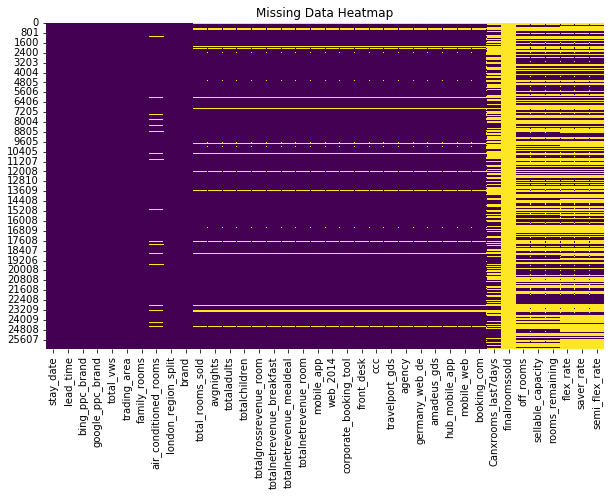

In [22]:
# Create a heatmap of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

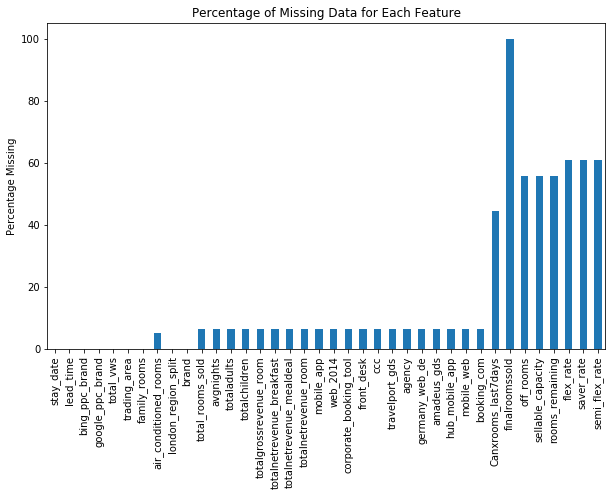

In [23]:
# Calculate the percentage of missing data for each feature
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Create a bar plot of missing data percentage
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.ylabel('Percentage Missing')
plt.title('Percentage of Missing Data for Each Feature')
plt.show()

In [24]:
data = data.drop(['finalroomssold'],axis=1)

In [25]:
# Date 
data['date'] = data['stay_date'].dt.date
data['time'] = data['stay_date'].dt.time

print("date", data['date'].unique())
print("\ntime", data['time'].unique())

date [datetime.date(2021, 5, 1) datetime.date(2021, 5, 2)
 datetime.date(2021, 5, 3) datetime.date(2021, 5, 4)
 datetime.date(2021, 5, 5) datetime.date(2021, 5, 6)
 datetime.date(2021, 5, 7) datetime.date(2021, 5, 8)
 datetime.date(2021, 5, 9) datetime.date(2021, 5, 10)
 datetime.date(2021, 5, 11) datetime.date(2021, 5, 12)
 datetime.date(2021, 5, 13) datetime.date(2021, 5, 14)
 datetime.date(2021, 5, 15) datetime.date(2021, 5, 16)
 datetime.date(2021, 5, 17) datetime.date(2021, 5, 18)
 datetime.date(2021, 5, 19) datetime.date(2021, 5, 20)
 datetime.date(2021, 5, 21) datetime.date(2021, 5, 22)
 datetime.date(2021, 5, 23) datetime.date(2021, 5, 24)
 datetime.date(2021, 5, 25) datetime.date(2021, 5, 26)
 datetime.date(2021, 5, 27) datetime.date(2021, 5, 28)
 datetime.date(2021, 5, 29) datetime.date(2021, 5, 30)]

time [datetime.time(0, 0)]


In [26]:
data['Day'] = data['stay_date'].dt.day
data['Day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [27]:
data['Month'] = data['stay_date'].dt.month
data['Month'].unique()

array([5], dtype=int64)

In [28]:
data['Year'] = data['stay_date'].dt.year
data['Year'].unique()

array([2021], dtype=int64)

In [29]:
data['dayofweek'] = data['stay_date'].dt.dayofweek
data['dayofweek'].unique()

array([5, 6, 0, 1, 2, 3, 4], dtype=int64)

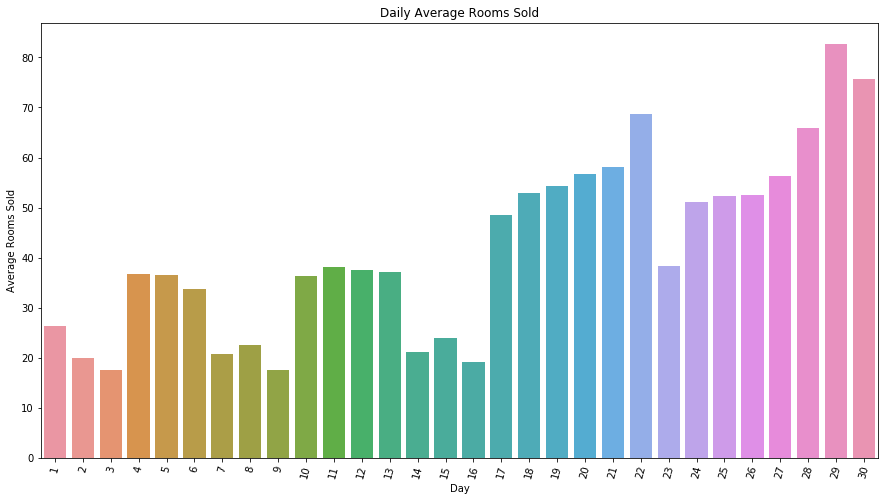

In [30]:
# To understand the relationship between the Day feature and total_rooms_sold

# Group data by 'Day' and calculate the mean of 'total_rooms_sold'
daily_rooms_sold = data.groupby('Day')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=daily_rooms_sold.index, y=daily_rooms_sold.values)
plt.xlabel('Day')
plt.ylabel('Average Rooms Sold')
plt.title('Daily Average Rooms Sold')
plt.xticks(rotation=75)
plt.show()

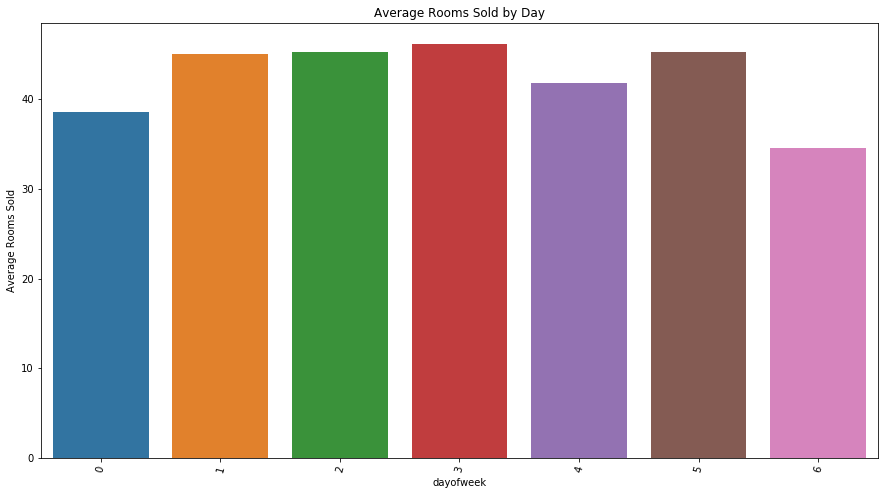

In [31]:
# To understand the relationship between the dayofweek feature and total_rooms_sold

# Group data by 'dayofweek' and calculate the mean of 'total_rooms_sold'
day_rooms_sold = data.groupby('dayofweek')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=day_rooms_sold.index, y=day_rooms_sold.values)
plt.xlabel('dayofweek')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Day')
plt.xticks(rotation=75)
plt.show()

In [32]:
data['lead_time'].unique()

array([3], dtype=int64)

In [33]:
# drop lead_time because of constant
data = data.drop(['lead_time'],axis=1)

In [34]:
data[(data['google_ppc_brand']+data['bing_ppc_brand'])!=data['total_vws']].shape[0]

0

In [35]:
# drop google_ppc_brand and bing_ppc_brand because of duplicate data

"""
we can remove google_ppc_brand and bing_ppc_brand or total_vws; it should be discuss with Subject Matter Experts.
"""

data = data.drop(['google_ppc_brand','bing_ppc_brand'],axis=1)

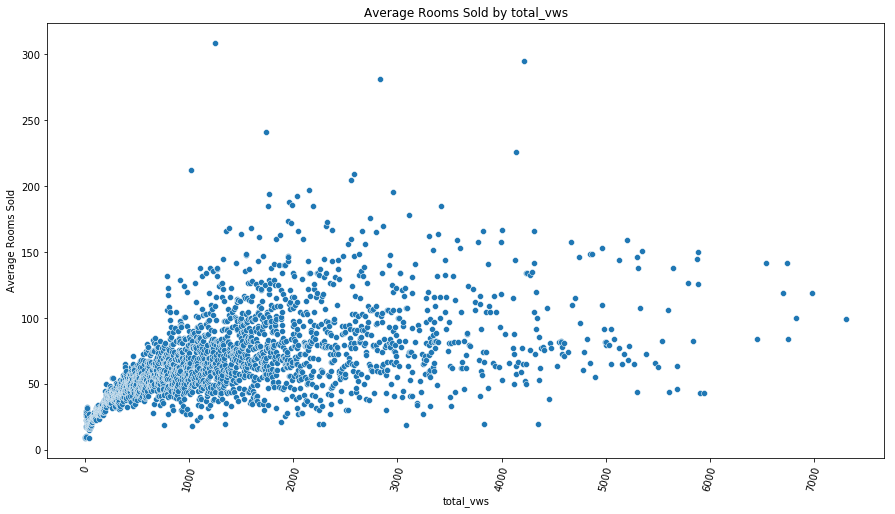

In [36]:
# To understand the relationship between the total_vws feature and total_rooms_sold

"""
Total digital visits recorded for the stay date and hotel
"""

# Group data by 'total_vws' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_total_vws = data.groupby('total_vws')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_total_vws.index, y=rooms_sold_by_total_vws.values)
plt.xlabel('total_vws')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by total_vws')
plt.xticks(rotation=75)
plt.show()

In [37]:
data['trading_area'].unique()

array(['Scotland East', 'North Home Counties', 'North East',
       'Gloucester/Worcester/Hereford', 'West Midlands', 'Merseyside',
       'Kent', 'Sussex/Surrey', 'Leeds/Bradford', 'Germany Northwest',
       'Wales', 'Germany Southeast', 'East Anglia', 'M4 Corridor',
       'Greater Manchester', 'Scotland North', 'Northern Ireland',
       'Outer London Area', 'Scotland West', 'Bristol/Somerset',
       'Cornwall/Devon', 'South Coast', 'Central London Area',
       'Inner London Area', 'Yorkshire', 'Essex', 'Cheshire/Shropshire',
       'Airports Area', 'Portsmouth/Southampton', 'Lancashire/Cumbria',
       'East Midlands', 'Peak District/Lincolnshire',
       'Oxfordshire/Buckinghamshire', 'Republic of Ireland'], dtype=object)

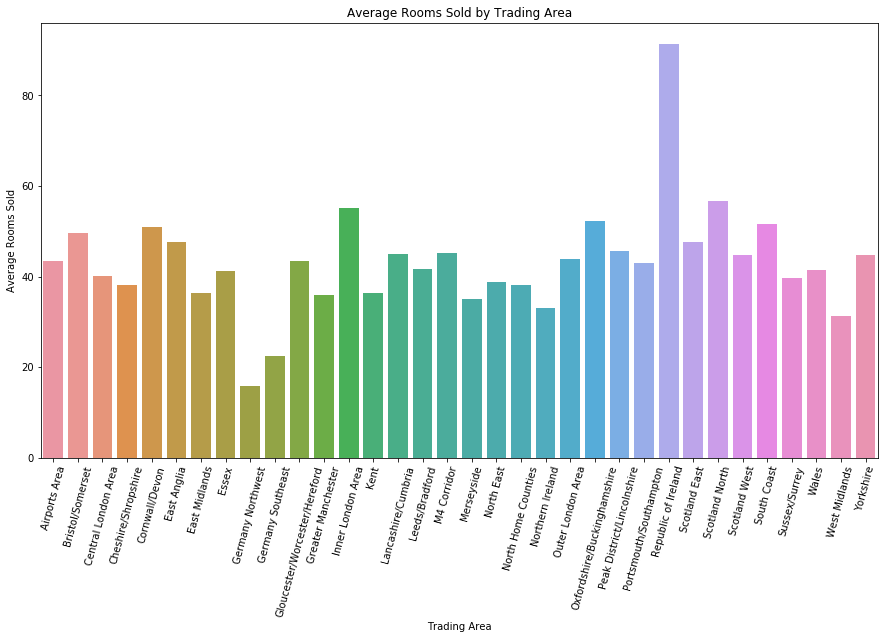

In [38]:
# To understand the relationship between the trading_area feature and total_rooms_sold

# Group data by 'trading_area' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_trading_area = data.groupby('trading_area')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_trading_area.index, y=rooms_sold_by_trading_area.values)
plt.xlabel('Trading Area')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Trading Area')
plt.xticks(rotation=75)
plt.show()

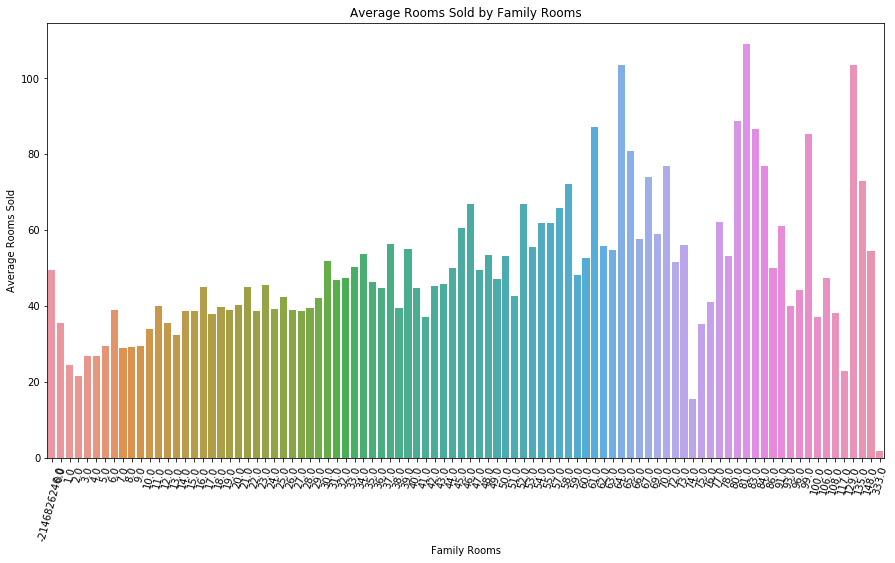

In [39]:
# To understand the relationship between the family_rooms feature and total_rooms_sold

# Group data by 'family_rooms' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_family_rooms = data.groupby('family_rooms')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_family_rooms.index, y=rooms_sold_by_family_rooms.values)
plt.xlabel('Family Rooms')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Family Rooms')
plt.xticks(rotation=75)
plt.show()

In [40]:
data['air_conditioned_rooms'].unique()

array(['No Air Con', 'All rooms have air con.',
       'All rooms and whole hotel has air ,conditioning.',
       'All areas are air conditioned', '0',
       'All rooms have air con.,No air con in reception.',
       'All rooms have air con', nan, 'All areas air conditioned',
       'All rooms and whole hotel has air con.',
       'All areas are air conditioned.',
       'All rooms have air conditioning', 'All areas air conditioned.',
       'All rooms have brand new powerful aircon',
       'All room have air con.', 'all rooms have air con',
       'All rooms/whole hotel has air con.',
       'All rooms have brand new powerful,aircon.',
       'All airs are air-conditioned.', 'All rooms are air conditioned.',
       'All areas have air con.',
       'All rooms at the this hotel have,air confitioning',
       'All rooms, reception and reception has ,air conditioning.',
       'All rooms air conditioned.',
       'All rooms and restaurant have air con.',
       'All rooms and reception

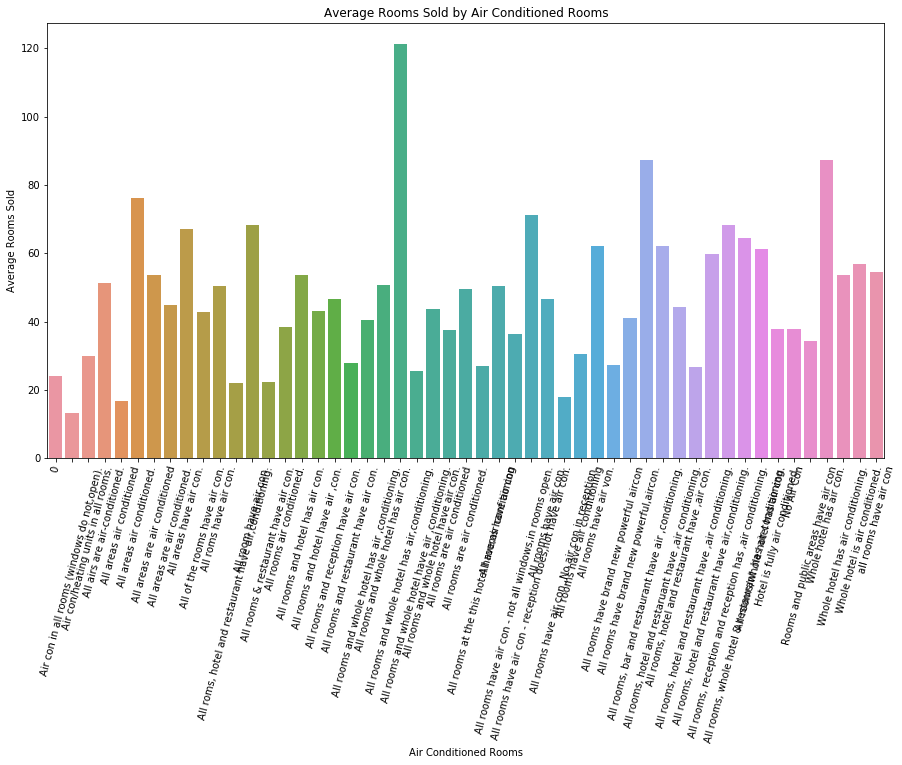

In [41]:
# To understand the relationship between the air_conditioned_rooms feature and total_rooms_sold

# Group data by 'air_conditioned_rooms' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_air_conditioned_rooms = data.groupby('air_conditioned_rooms')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_air_conditioned_rooms.index, y=rooms_sold_by_air_conditioned_rooms.values)
plt.xlabel('Air Conditioned Rooms')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Air Conditioned Rooms')
plt.xticks(rotation=75)
plt.show()

In [42]:
# Handle inconsistencies in air_conditioned_rooms
data['air_conditioned_rooms'] = data['air_conditioned_rooms'].fillna('0')
data['air_conditioned_rooms'] = data['air_conditioned_rooms'].str.lower()

# List of substrings to replace
substrings_to_replace_all_rooms = ['all','fully','whole','rooms']
substrings_to_replace_no_AC = ['no', '0']

# Replace values in the DataFrame based on the substrings
for substr in substrings_to_replace_all_rooms:
    data.loc[data['air_conditioned_rooms'].str.contains(substr), 'air_conditioned_rooms'] = 'Yes'

for substr in substrings_to_replace_no_AC:
    data.loc[data['air_conditioned_rooms'].str.contains(substr), 'air_conditioned_rooms'] = 'No'

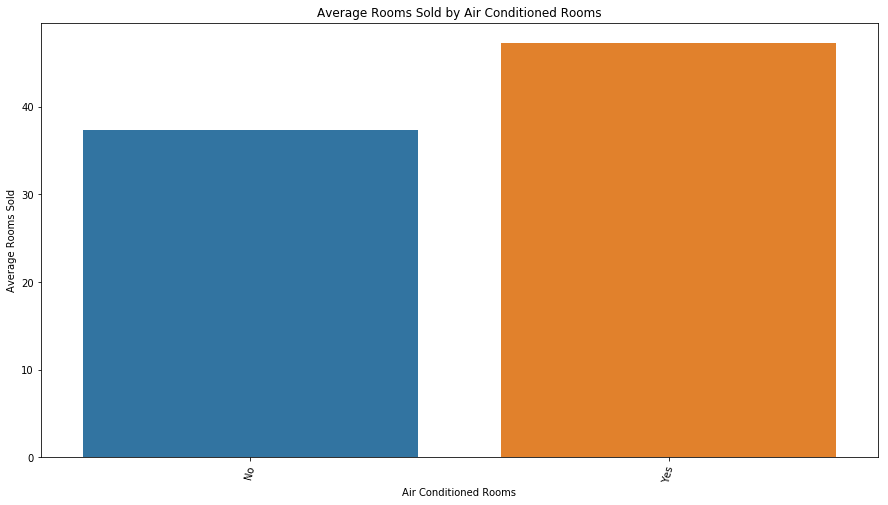

In [43]:
# To understand the relationship between the air_conditioned_rooms feature and total_rooms_sold

# Group data by 'air_conditioned_rooms' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_air_conditioned_rooms = data.groupby('air_conditioned_rooms')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_air_conditioned_rooms.index, y=rooms_sold_by_air_conditioned_rooms.values)
plt.xlabel('Air Conditioned Rooms')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Air Conditioned Rooms')
plt.xticks(rotation=75)
plt.show()

In [44]:
data['brand'].unique()

array(['Premier Inn', 'Premier Inn Germany', 'ZIP by Premier Inn',
       'hub by Premier Inn'], dtype=object)

In [45]:
data[data['total_rooms_sold'].isnull()]['brand'].unique()

array(['Premier Inn', 'Premier Inn Germany', 'hub by Premier Inn'],
      dtype=object)

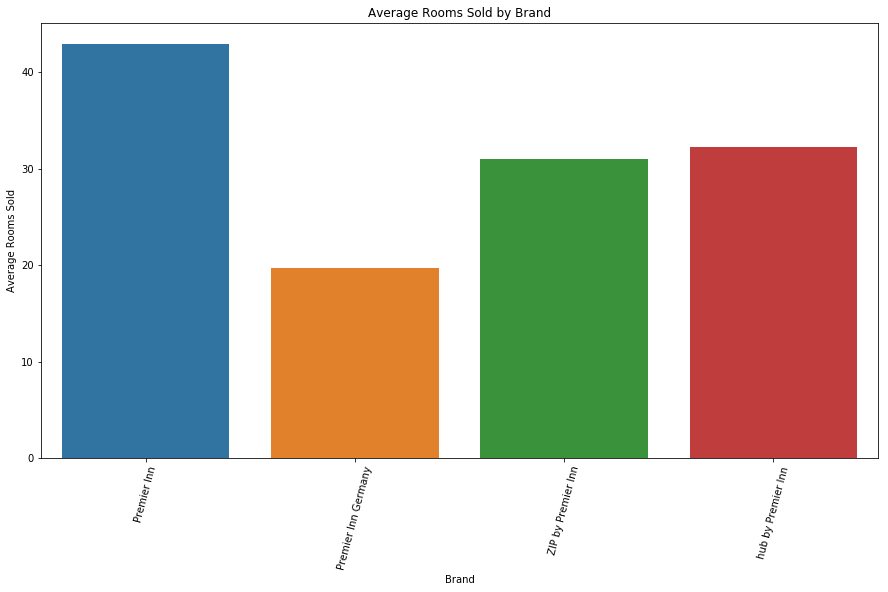

In [46]:
# To understand the relationship between the air_conditioned_rooms feature and total_rooms_sold

# Group data by 'air_conditioned_rooms' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_brand = data.groupby('brand')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_brand.index, y=rooms_sold_by_brand.values)
plt.xlabel('Brand')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Brand')
plt.xticks(rotation=75)
plt.show()

In [47]:
data['london_region_split'].unique()

array(['Regions', 'Germany', 'London'], dtype=object)

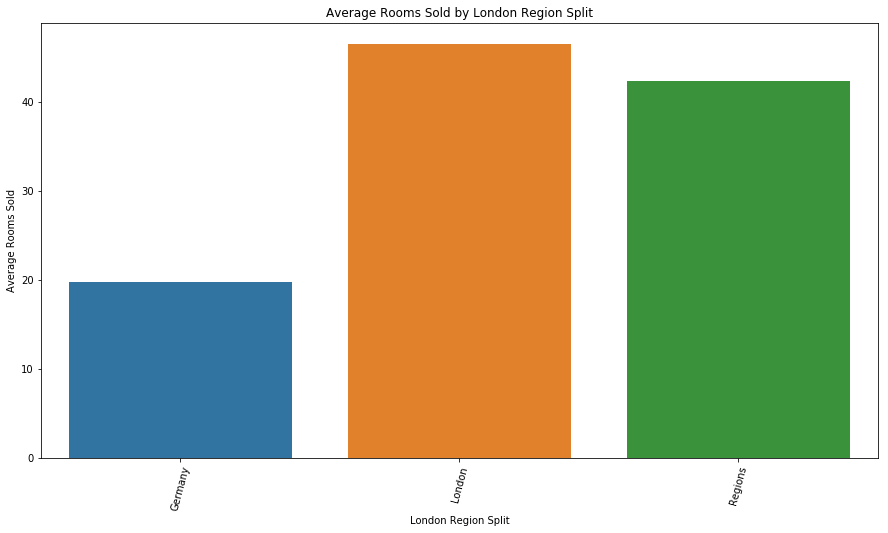

In [48]:
# To understand the relationship between the london_region_split feature and total_rooms_sold

# Group data by 'london_region_split' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_london_region_split = data.groupby('london_region_split')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_london_region_split.index, y=rooms_sold_by_london_region_split.values)
plt.xlabel('London Region Split')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by London Region Split')
plt.xticks(rotation=75)
plt.show()

In [49]:
data = data[~data['total_rooms_sold'].isnull()]

In [50]:
data.shape

(24645, 40)

In [51]:
data.columns

Index(['stay_date', 'total_vws', 'trading_area', 'family_rooms',
       'air_conditioned_rooms', 'london_region_split', 'brand',
       'total_rooms_sold', 'avgnights', 'totaladults', 'totalchildren',
       'totalgrossrevenue_room', 'totalnetrevenue_breakfast',
       'totalnetrevenue_mealdeal', 'totalnetrevenue_room', 'mobile_app',
       'web_2014', 'corporate_booking_tool', 'front_desk', 'ccc',
       'travelport_gds', 'agency', 'germany_web_de', 'amadeus_gds',
       'hub_mobile_app', 'mobile_web', 'booking_com', 'Canxrooms_last7days',
       'off_rooms', 'sellable_capacity', 'rooms_remaining', 'flex_rate',
       'saver_rate', 'semi_flex_rate', 'date', 'time', 'Day', 'Month', 'Year',
       'dayofweek'],
      dtype='object')

In [52]:
data.isnull().sum()

stay_date                        0
total_vws                        0
trading_area                     0
family_rooms                     0
air_conditioned_rooms            0
london_region_split              0
brand                            0
total_rooms_sold                 0
avgnights                        0
totaladults                      0
totalchildren                    0
totalgrossrevenue_room           0
totalnetrevenue_breakfast        0
totalnetrevenue_mealdeal         0
totalnetrevenue_room             0
mobile_app                       0
web_2014                         0
corporate_booking_tool           0
front_desk                       0
ccc                              0
travelport_gds                   0
agency                           0
germany_web_de                   0
amadeus_gds                      0
hub_mobile_app                   0
mobile_web                       0
booking_com                      0
Canxrooms_last7days          10212
off_rooms           

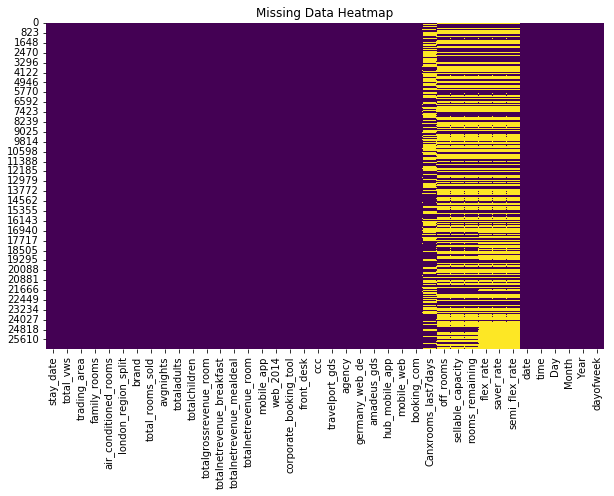

In [53]:
# Create a heatmap of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


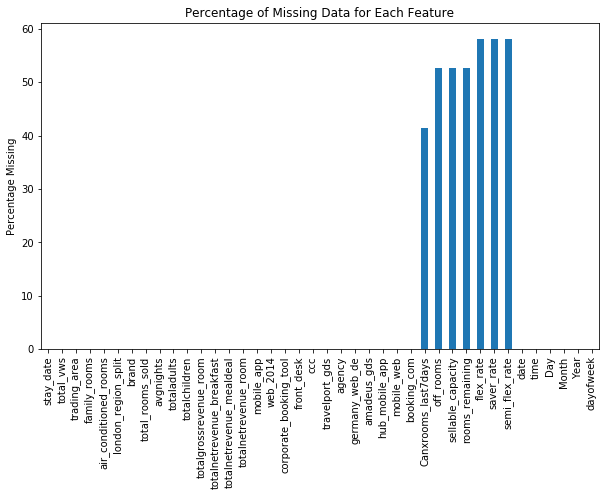

In [54]:
# Calculate the percentage of missing data for each feature
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Create a bar plot of missing data percentage
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.ylabel('Percentage Missing')
plt.title('Percentage of Missing Data for Each Feature')
plt.show()

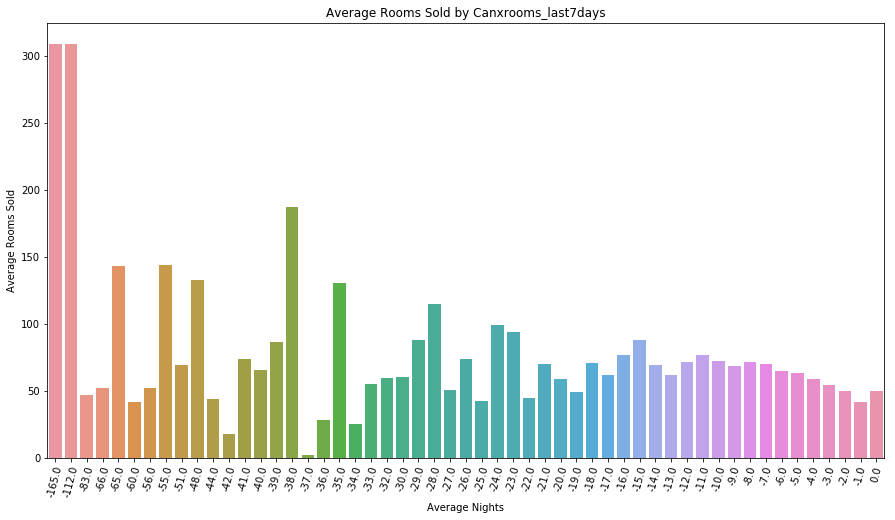

In [55]:
# To understand the relationship between the Canxrooms_last7days feature and total_rooms_sold

# Group data by 'Canxrooms_last7days' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_avgnights = data.groupby('Canxrooms_last7days')['total_rooms_sold'].mean()

# Plot the Canxrooms_last7days in each trading area
plt.figure(figsize=(15, 8))
sns.barplot(x=rooms_sold_by_avgnights.index, y=rooms_sold_by_avgnights.values)
plt.xlabel('Average Nights')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Canxrooms_last7days')
plt.xticks(rotation=75)
plt.show()

In [56]:
# Impute 'Canxrooms_last7days' based on 'total_rooms_sold'
data['Canxrooms_last7days'] = data.groupby('total_rooms_sold')['Canxrooms_last7days'].transform(lambda x: x.fillna(x.mean()))

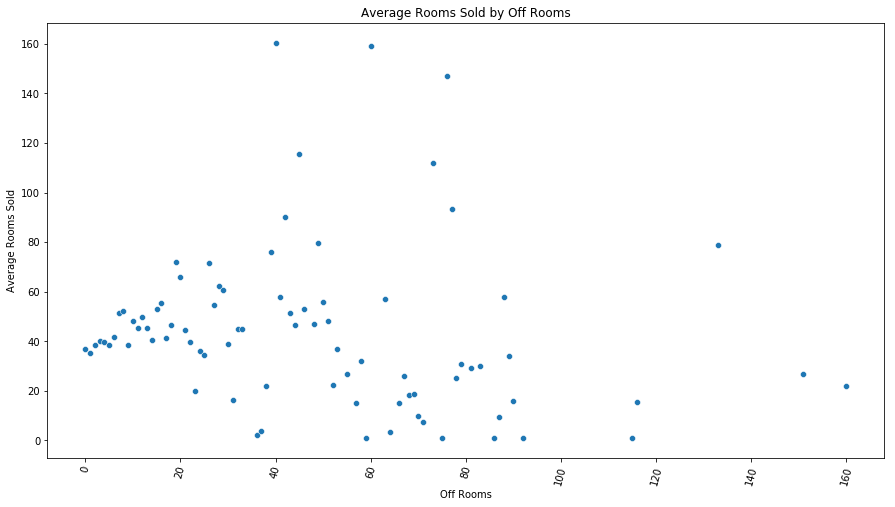

In [57]:
# To understand the relationship between the off_rooms feature and total_rooms_sold

# Group data by 'off_rooms' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_OffRooms = data.groupby('off_rooms')['total_rooms_sold'].mean()

# Plot the off_rooms in each trading area
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_OffRooms.index, y=rooms_sold_by_OffRooms.values)
plt.xlabel('Off Rooms')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Off Rooms')
plt.xticks(rotation=75)
plt.show()

In [58]:
# Impute 'off_rooms' based on 'total_rooms_sold'
data['off_rooms'] = data.groupby('total_rooms_sold')['off_rooms'].transform(lambda x: x.fillna(x.mean()))

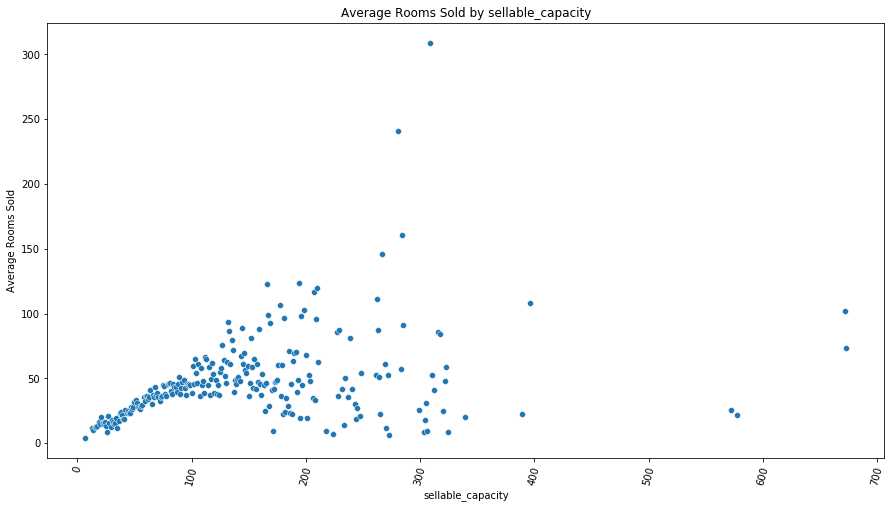

In [59]:
# To understand the relationship between the sellable_capacity feature and total_rooms_sold

# Group data by 'sellable_capacity' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_sellable_capacity = data.groupby('sellable_capacity')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_sellable_capacity.index, y=rooms_sold_by_sellable_capacity.values)
plt.xlabel('sellable_capacity')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by sellable_capacity')
plt.xticks(rotation=75)
plt.show()

In [60]:
# Impute 'sellable_capacity' based on 'total_rooms_sold'
data['sellable_capacity'] = data.groupby('total_rooms_sold')['sellable_capacity'].transform(lambda x: x.fillna(x.mean()))

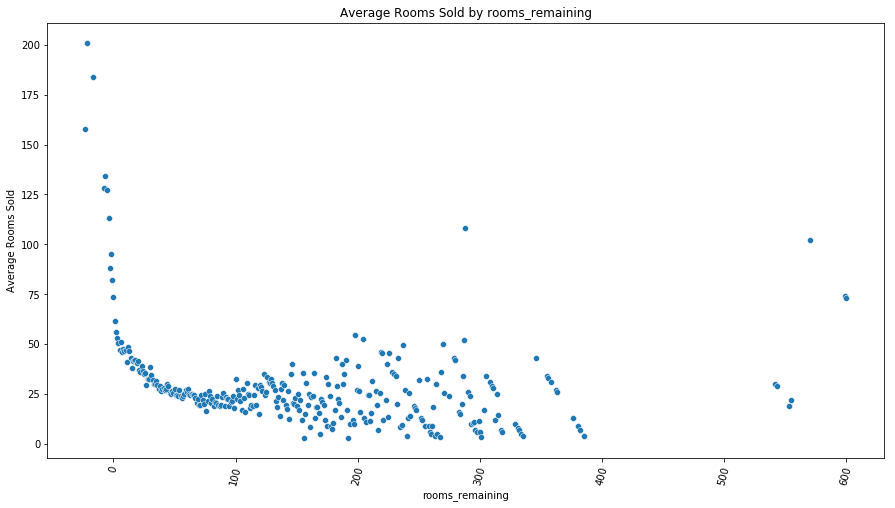

In [61]:
# To understand the relationship between the rooms_remaining feature and total_rooms_sold

# Group data by 'rooms_remaining' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_rooms_remaining = data.groupby('rooms_remaining')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_rooms_remaining.index, y=rooms_sold_by_rooms_remaining.values)
plt.xlabel('rooms_remaining')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by rooms_remaining')
plt.xticks(rotation=75)
plt.show()


In [62]:
# Impute 'rooms_remaining' based on 'total_rooms_sold'
data['rooms_remaining'] = data.groupby('total_rooms_sold')['rooms_remaining'].transform(lambda x: x.fillna(x.mean()))

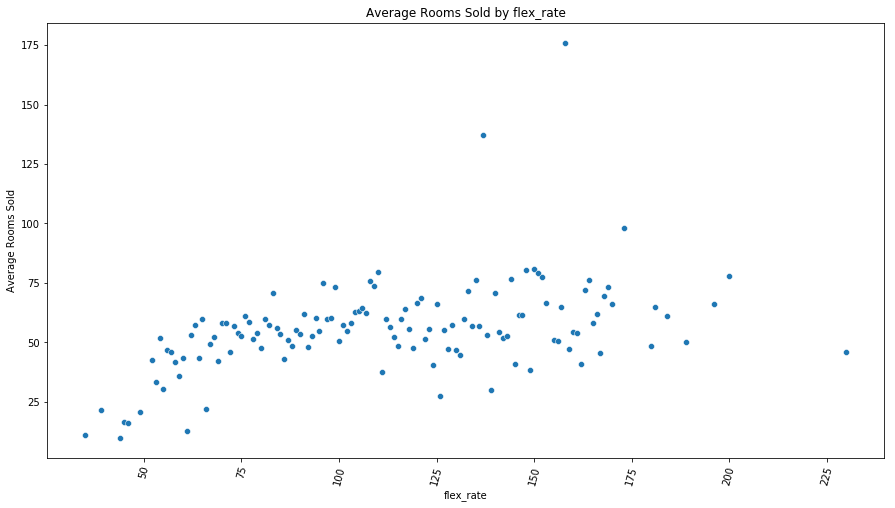

In [63]:
# To understand the relationship between the flex_rate feature and total_rooms_sold

# Group data by 'flex_rate' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_flex_rate = data.groupby('flex_rate')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_flex_rate.index, y=rooms_sold_by_flex_rate.values)
plt.xlabel('flex_rate')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by flex_rate')
plt.xticks(rotation=75)
plt.show()

In [64]:
# Impute 'flex_rate' based on 'total_rooms_sold'
data['flex_rate'] = data.groupby('total_rooms_sold')['flex_rate'].transform(lambda x: x.fillna(x.mean()))
data['flex_rate'] = data['flex_rate'].fillna(data['flex_rate'].mean())

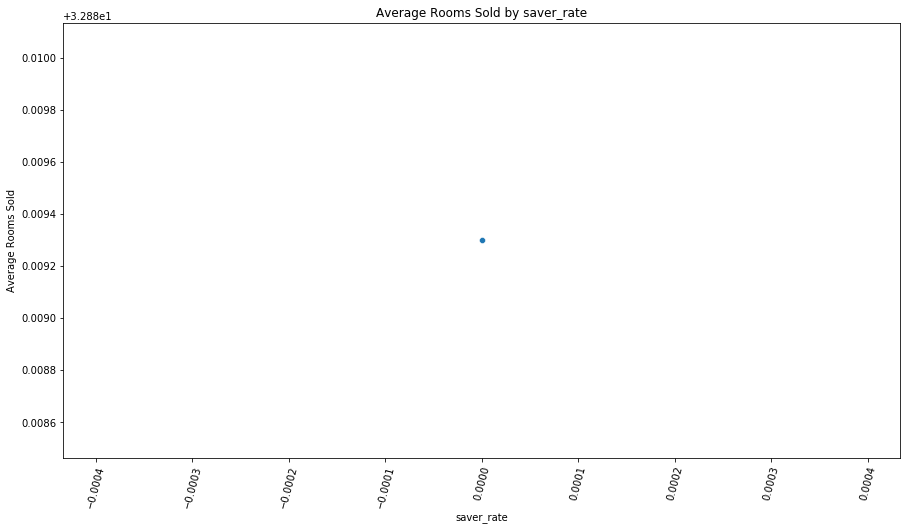

In [65]:
# To understand the relationship between the saver_rate feature and total_rooms_sold

# Group data by 'saver_rate' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_saver_rate = data.groupby('saver_rate')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_saver_rate.index, y=rooms_sold_by_saver_rate.values)
plt.xlabel('saver_rate')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by saver_rate')
plt.xticks(rotation=75)
plt.show()

In [66]:
data = data.drop(['saver_rate'],axis=1)

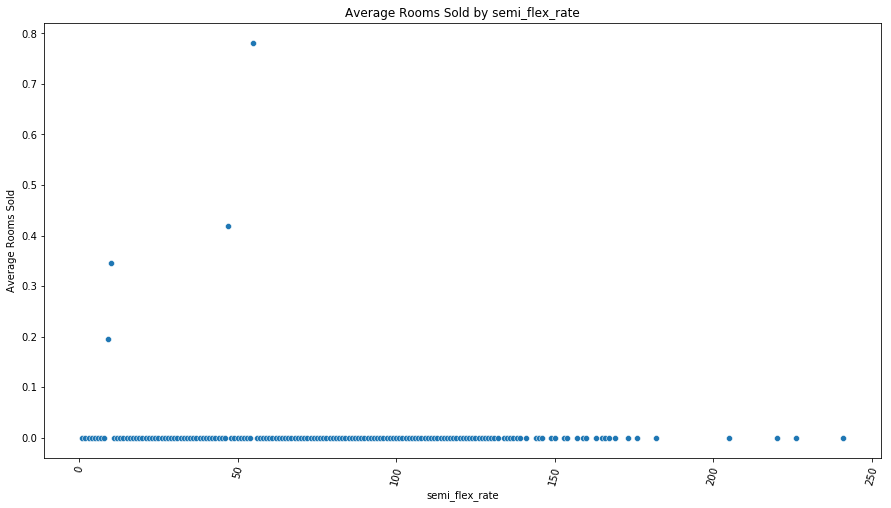

In [67]:
# To understand the relationship between the semi_flex_rate feature and total_rooms_sold

# Group data by 'semi_flex_rate' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_semi_flex_rate = data.groupby('total_rooms_sold')['semi_flex_rate'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_semi_flex_rate.index, y=rooms_sold_by_semi_flex_rate.values)
plt.xlabel('semi_flex_rate')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by semi_flex_rate')
plt.xticks(rotation=75)
plt.show()

In [68]:
data = data.drop(['semi_flex_rate'],axis=1)

In [69]:
data['avgnights'].unique()

array([ 2.,  4.,  3.,  1.,  6.,  5.,  8., 16.,  7., 31.,  9., 12., 13.,
       11., 25., 23., 14., 10., 17., 15., 21., 30., 28., 22., 19., 32.,
       26., 29., 34.])

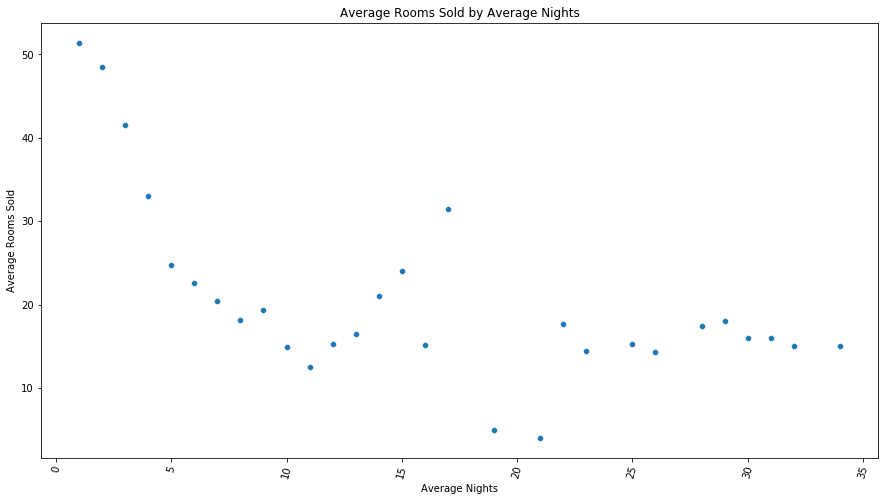

In [70]:
# To understand the relationship between the avgnights feature and total_rooms_sold

# Group data by 'avgnights' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_avgnights = data.groupby('avgnights')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_avgnights.index, y=rooms_sold_by_avgnights.values)
plt.xlabel('Average Nights')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Average Nights')
plt.xticks(rotation=75)
plt.show()

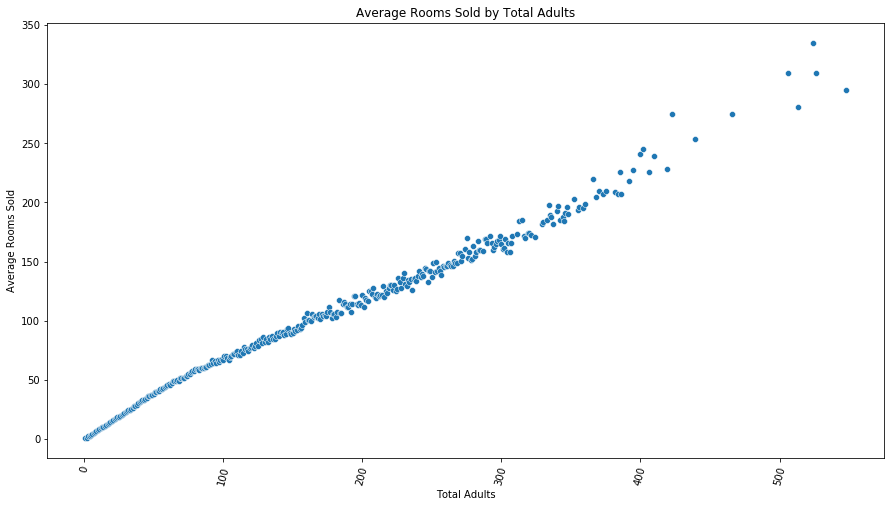

In [71]:
# To understand the relationship between the totaladults feature and total_rooms_sold

# Group data by 'totaladults' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totaladults= data.groupby('totaladults')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totaladults.index, y=rooms_sold_by_totaladults.values)
plt.xlabel('Total Adults')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Total Adults')
plt.xticks(rotation=75)
plt.show()

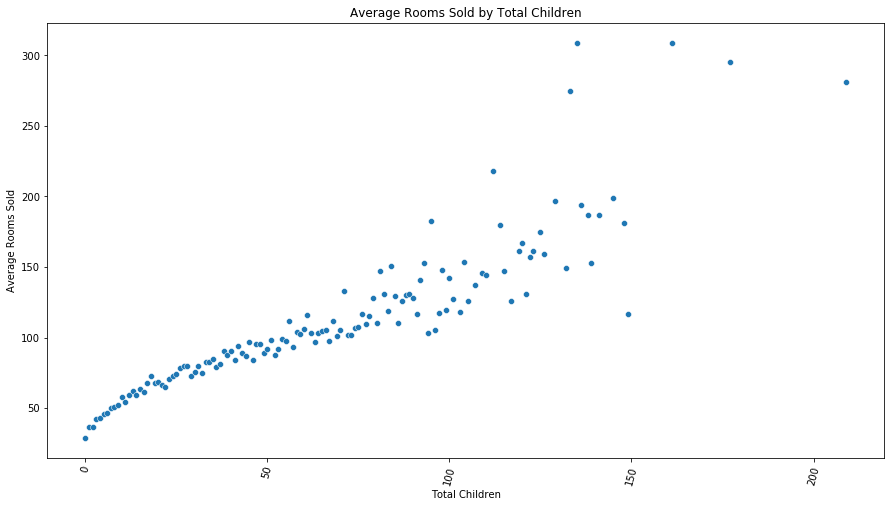

In [72]:
# To understand the relationship between the totalchildren feature and total_rooms_sold

# Group data by 'totalchildren' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totalchildren= data.groupby('totalchildren')['total_rooms_sold'].mean()

# Plot the average rooms sold in each trading area
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totalchildren.index, y=rooms_sold_by_totalchildren.values)
plt.xlabel('Total Children')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by Total Children')
plt.xticks(rotation=75)
plt.show()

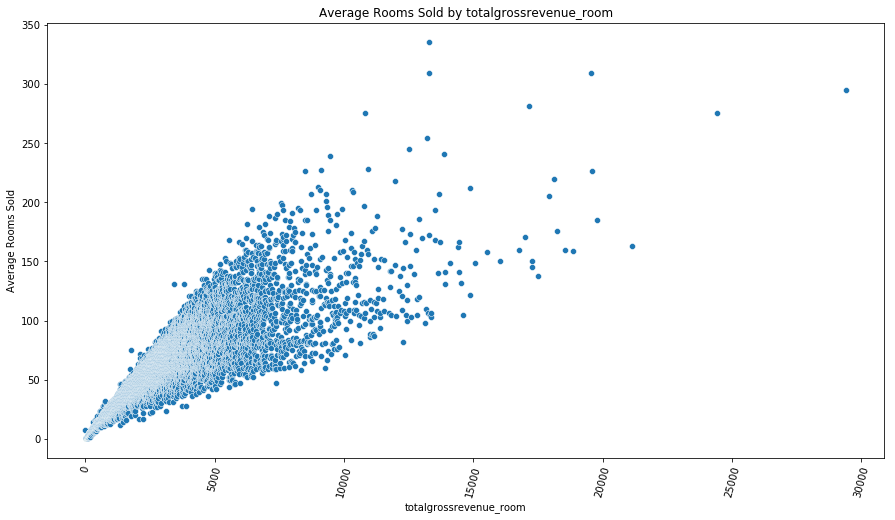

In [73]:
# To understand the relationship between the totalgrossrevenue_room feature and total_rooms_sold

# Group data by 'totalgrossrevenue_room' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totalgrossrevenue_room= data.groupby('totalgrossrevenue_room')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totalgrossrevenue_room.index, y=rooms_sold_by_totalgrossrevenue_room.values)
plt.xlabel('totalgrossrevenue_room')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by totalgrossrevenue_room')
plt.xticks(rotation=75)
plt.show()

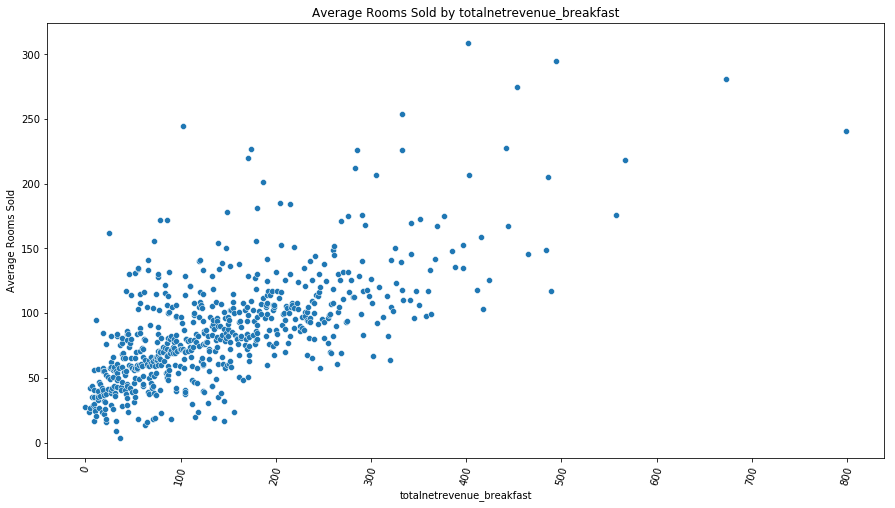

In [74]:
# To understand the relationship between the totalnetrevenue_breakfast feature and total_rooms_sold

# Group data by 'totalnetrevenue_breakfast' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totalnetrevenue_breakfast= data.groupby('totalnetrevenue_breakfast')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totalnetrevenue_breakfast.index, y=rooms_sold_by_totalnetrevenue_breakfast.values)
plt.xlabel('totalnetrevenue_breakfast')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by totalnetrevenue_breakfast')
plt.xticks(rotation=75)
plt.show()

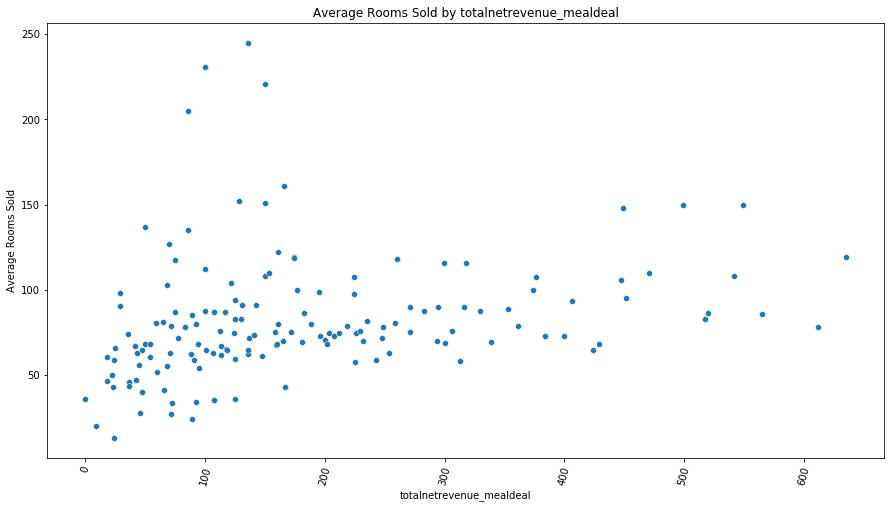

In [75]:
# To understand the relationship between the totalnetrevenue_mealdeal feature and total_rooms_sold

# Group data by 'totalnetrevenue_mealdeal' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totalnetrevenue_mealdeal= data.groupby('totalnetrevenue_mealdeal')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totalnetrevenue_mealdeal.index, y=rooms_sold_by_totalnetrevenue_mealdeal.values)
plt.xlabel('totalnetrevenue_mealdeal')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by totalnetrevenue_mealdeal')
plt.xticks(rotation=75)
plt.show()

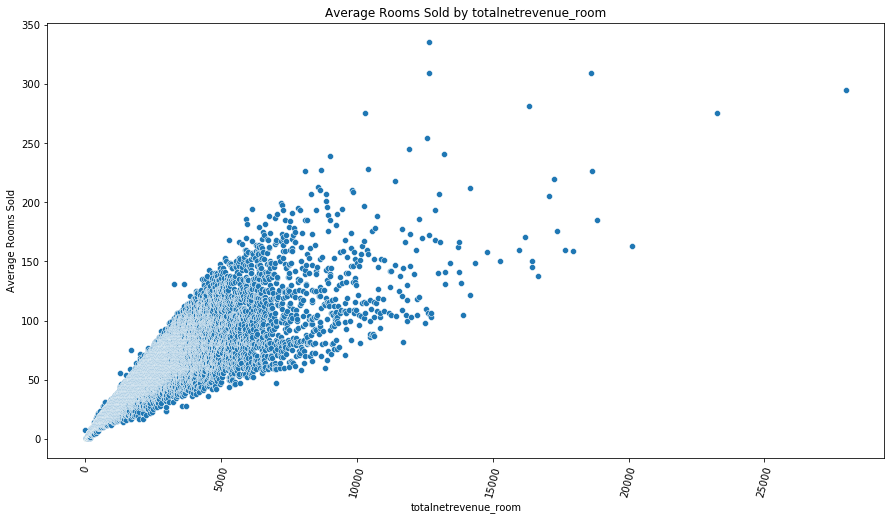

In [76]:
# To understand the relationship between the totalnetrevenue_room feature and total_rooms_sold

# Group data by 'totalnetrevenue_room' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_totalnetrevenue_room= data.groupby('totalnetrevenue_room')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_totalnetrevenue_room.index, y=rooms_sold_by_totalnetrevenue_room.values)
plt.xlabel('totalnetrevenue_room')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by totalnetrevenue_room')
plt.xticks(rotation=75)
plt.show()

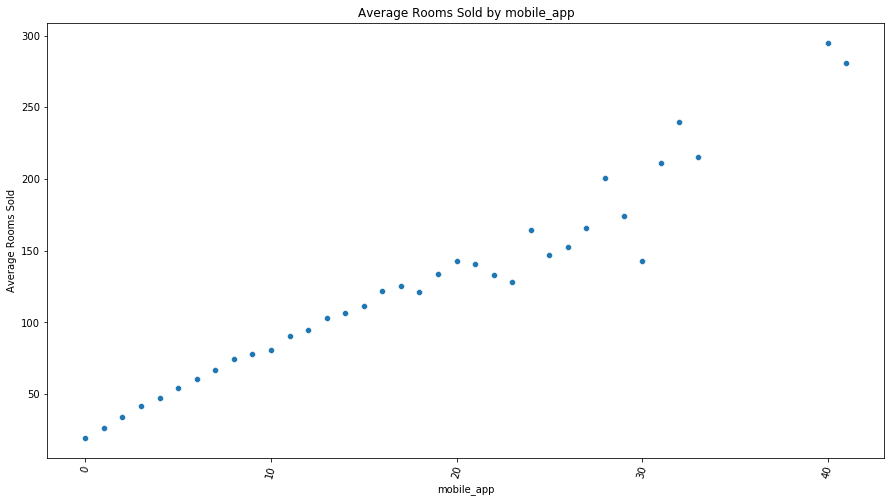

In [77]:
# To understand the relationship between the mobile_app feature and total_rooms_sold

# Group data by 'mobile_app' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_mobile_app= data.groupby('mobile_app')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_mobile_app.index, y=rooms_sold_by_mobile_app.values)
plt.xlabel('mobile_app')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by mobile_app')
plt.xticks(rotation=75)
plt.show()

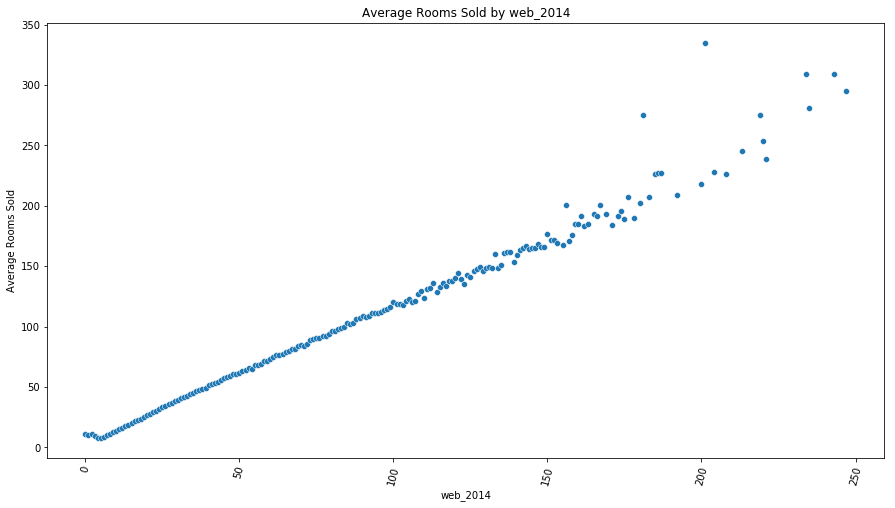

In [78]:
# To understand the relationship between the web_2014 feature and total_rooms_sold

# Group data by 'web_2014' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_web_2014= data.groupby('web_2014')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_web_2014.index, y=rooms_sold_by_web_2014.values)
plt.xlabel('web_2014')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by web_2014')
plt.xticks(rotation=75)
plt.show()

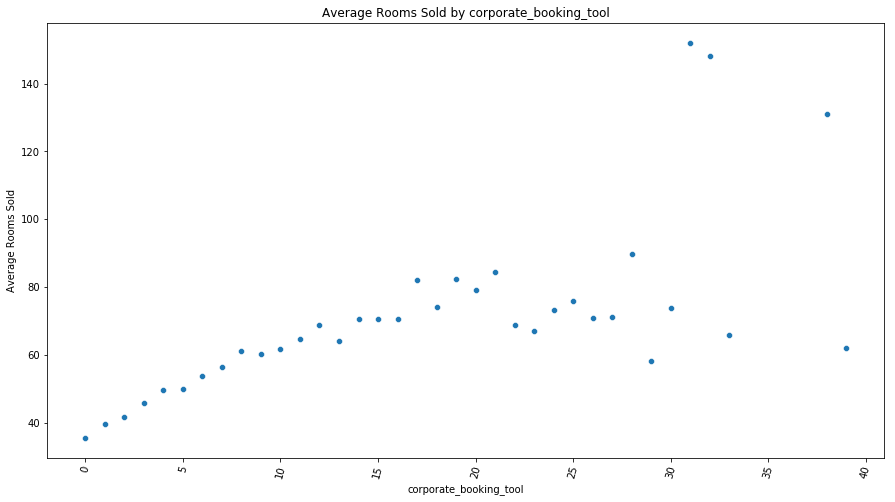

In [79]:
# To understand the relationship between the corporate_booking_tool feature and total_rooms_sold

# Group data by 'corporate_booking_tool' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_corporate_booking_tool = data.groupby('corporate_booking_tool')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_corporate_booking_tool.index, y=rooms_sold_by_corporate_booking_tool.values)
plt.xlabel('corporate_booking_tool')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by corporate_booking_tool')
plt.xticks(rotation=75)
plt.show()

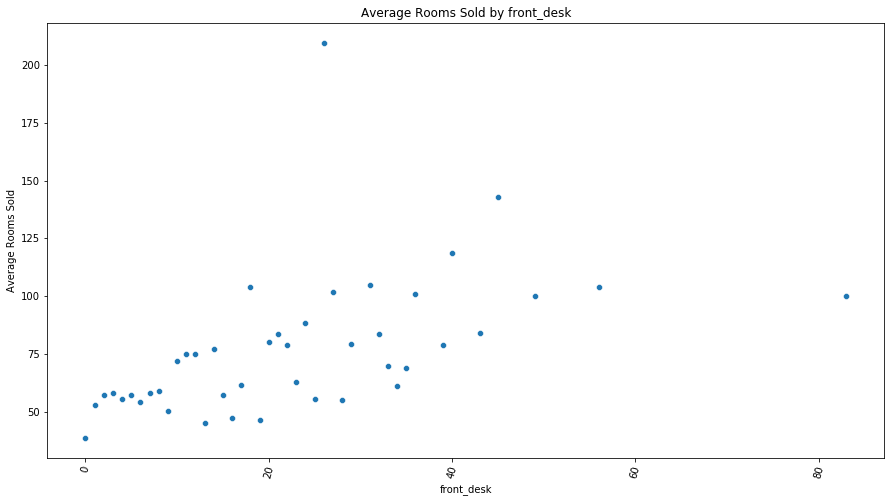

In [80]:
# To understand the relationship between the front_desk feature and total_rooms_sold

# Group data by 'front_desk' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_front_desk = data.groupby('front_desk')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_front_desk.index, y=rooms_sold_by_front_desk.values)
plt.xlabel('front_desk')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by front_desk')
plt.xticks(rotation=75)
plt.show()

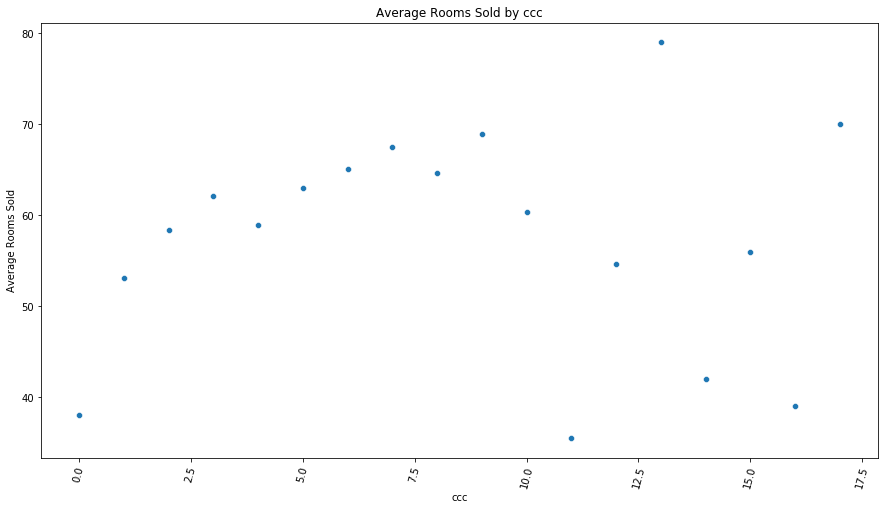

In [81]:
# To understand the relationship between the ccc feature and total_rooms_sold

# Group data by 'ccc' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_ccc = data.groupby('ccc')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_ccc.index, y=rooms_sold_by_ccc.values)
plt.xlabel('ccc')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by ccc')
plt.xticks(rotation=75)
plt.show()

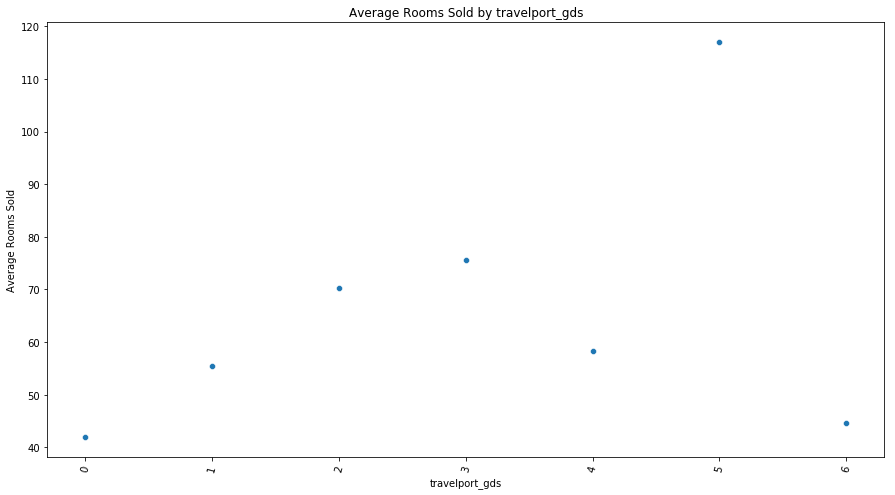

In [82]:
# To understand the relationship between the travelport_gds feature and total_rooms_sold

# Group data by 'travelport_gds' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_travelport_gds = data.groupby('travelport_gds')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_travelport_gds.index, y=rooms_sold_by_travelport_gds.values)
plt.xlabel('travelport_gds')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by travelport_gds')
plt.xticks(rotation=75)
plt.show()

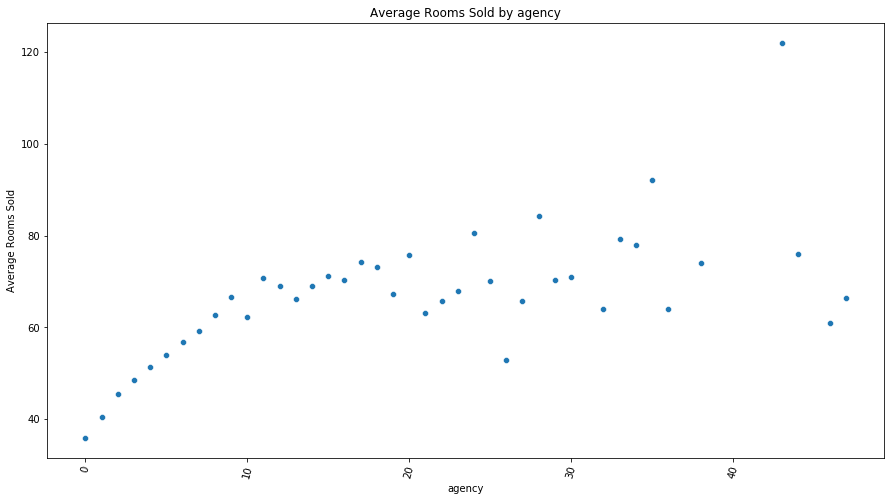

In [83]:
# To understand the relationship between the agency feature and total_rooms_sold

# Group data by 'agency' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_agency = data.groupby('agency')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_agency.index, y=rooms_sold_by_agency.values)
plt.xlabel('agency')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by agency')
plt.xticks(rotation=75)
plt.show()

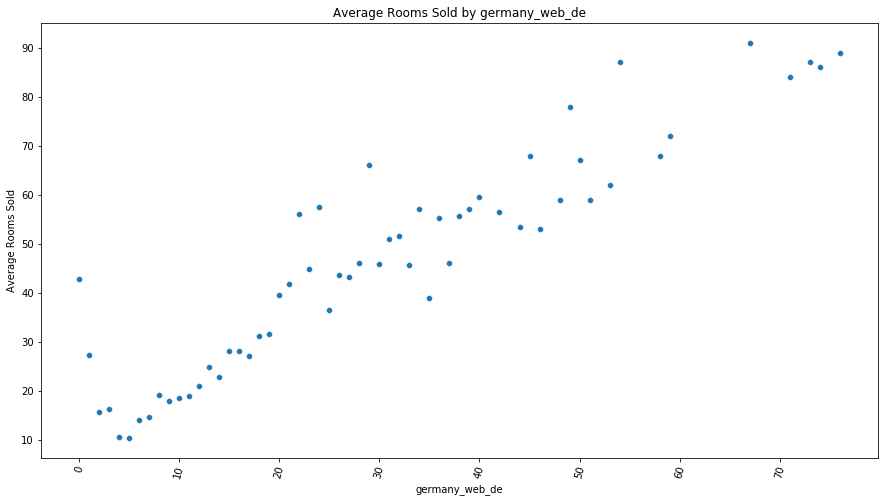

In [84]:
# To understand the relationship between the germany_web_de feature and total_rooms_sold

# Group data by 'germany_web_de' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_germany_web_de = data.groupby('germany_web_de')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_germany_web_de.index, y=rooms_sold_by_germany_web_de.values)
plt.xlabel('germany_web_de')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by germany_web_de')
plt.xticks(rotation=75)
plt.show()

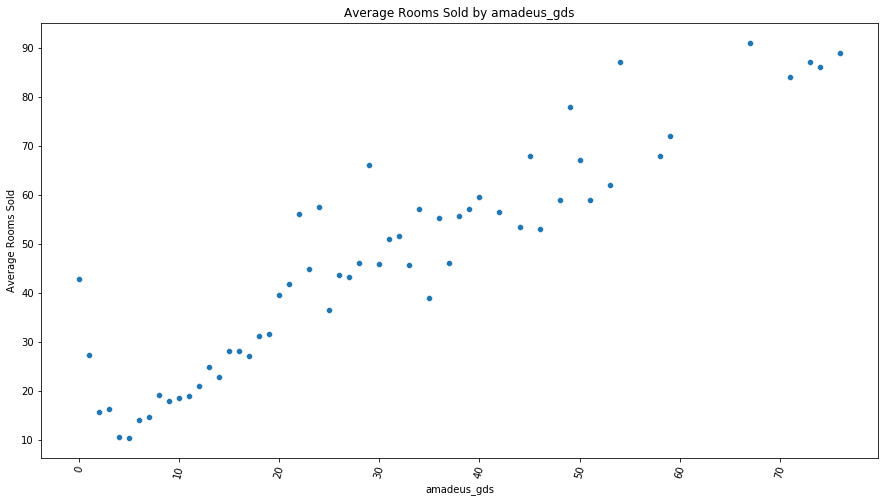

In [85]:
# To understand the relationship between the amadeus_gds feature and total_rooms_sold

# Group data by 'amadeus_gds' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_amadeus_gds = data.groupby('amadeus_gds')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_germany_web_de.index, y=rooms_sold_by_germany_web_de.values)
plt.xlabel('amadeus_gds')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by amadeus_gds')
plt.xticks(rotation=75)
plt.show()

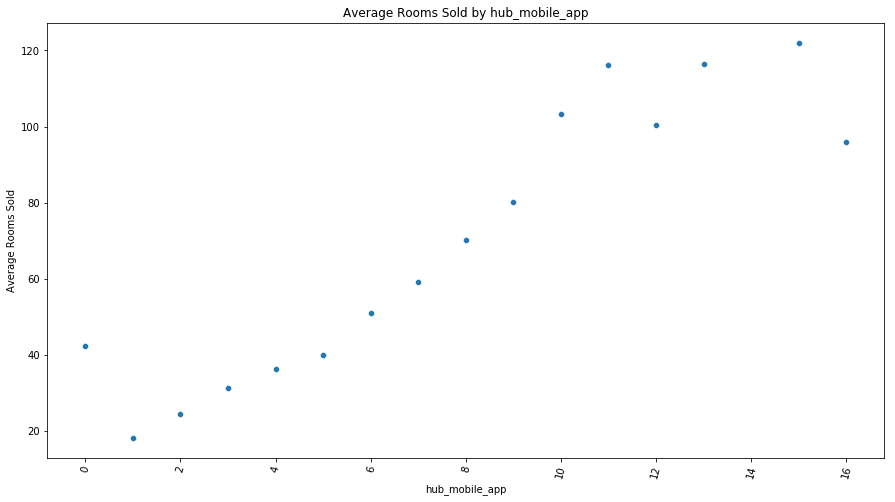

In [86]:
# To understand the relationship between the hub_mobile_app feature and total_rooms_sold

# Group data by 'hub_mobile_app' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_hub_mobile_app = data.groupby('hub_mobile_app')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_hub_mobile_app.index, y=rooms_sold_by_hub_mobile_app.values)
plt.xlabel('hub_mobile_app')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by hub_mobile_app')
plt.xticks(rotation=75)
plt.show()

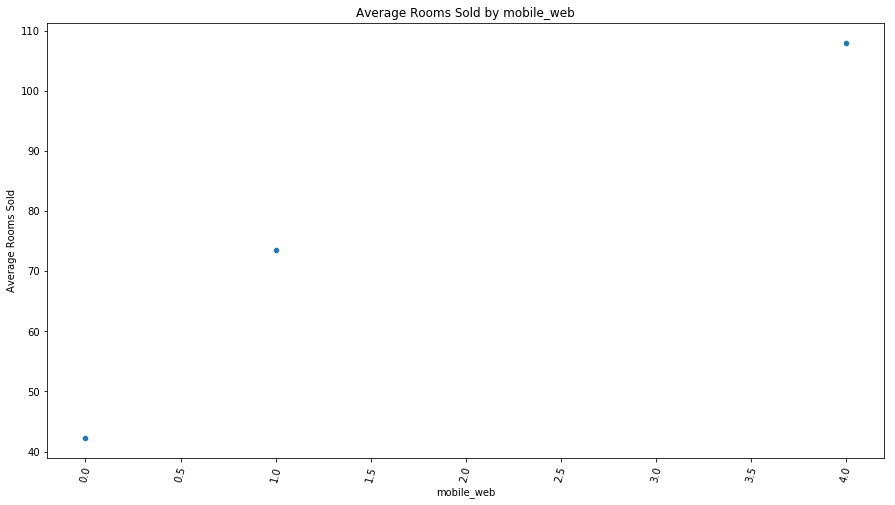

In [87]:
# To understand the relationship between the mobile_web feature and total_rooms_sold

# Group data by 'mobile_web' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_hub_mobile_web = data.groupby('mobile_web')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_hub_mobile_web.index, y=rooms_sold_by_hub_mobile_web.values)
plt.xlabel('mobile_web')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by mobile_web')
plt.xticks(rotation=75)
plt.show()

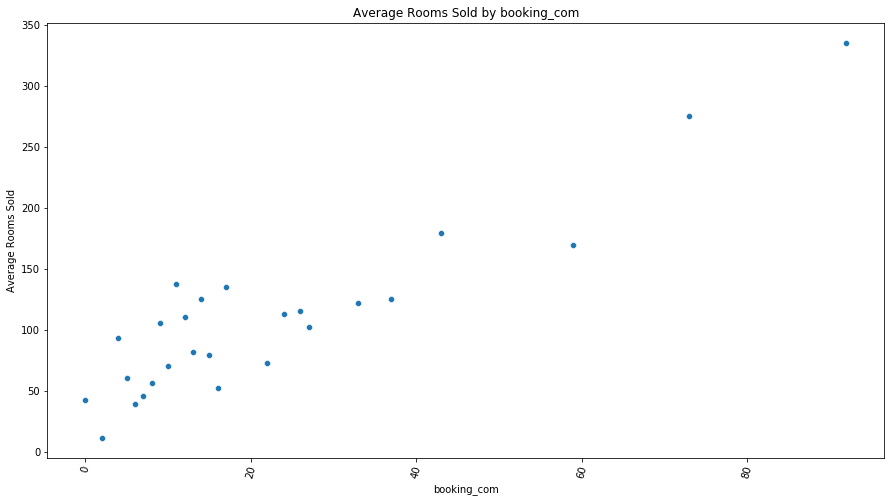

In [88]:
# To understand the relationship between the booking_com feature and total_rooms_sold

# Group data by 'booking_com' and calculate the mean of 'total_rooms_sold'
rooms_sold_by_hub_booking_com = data.groupby('booking_com')['total_rooms_sold'].mean()

# Plot the average rooms sold
plt.figure(figsize=(15, 8))
sns.scatterplot(x=rooms_sold_by_hub_booking_com.index, y=rooms_sold_by_hub_booking_com.values)
plt.xlabel('booking_com')
plt.ylabel('Average Rooms Sold')
plt.title('Average Rooms Sold by booking_com')
plt.xticks(rotation=75)
plt.show()

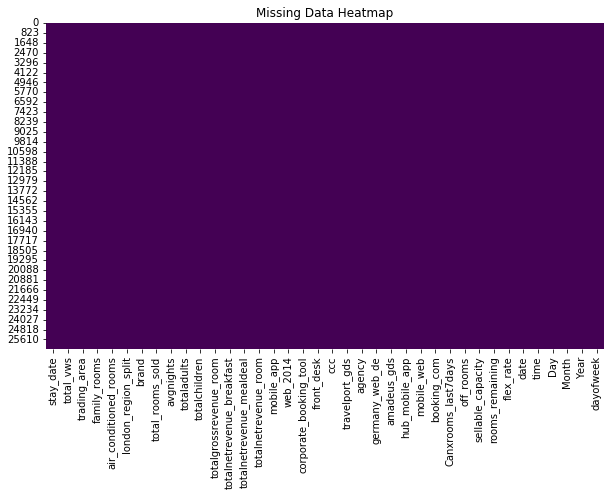

In [89]:
# Create a heatmap of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

In [90]:
data = data.drop(['stay_date','date','time','Month','Year'],axis=1)

In [91]:
data = data.drop(['avgnights','totalnetrevenue_mealdeal','corporate_booking_tool','ccc','travelport_gds'],axis=1)

In [92]:
data.columns

Index(['total_vws', 'trading_area', 'family_rooms', 'air_conditioned_rooms',
       'london_region_split', 'brand', 'total_rooms_sold', 'totaladults',
       'totalchildren', 'totalgrossrevenue_room', 'totalnetrevenue_breakfast',
       'totalnetrevenue_room', 'mobile_app', 'web_2014', 'front_desk',
       'agency', 'germany_web_de', 'amadeus_gds', 'hub_mobile_app',
       'mobile_web', 'booking_com', 'Canxrooms_last7days', 'off_rooms',
       'sellable_capacity', 'rooms_remaining', 'flex_rate', 'Day',
       'dayofweek'],
      dtype='object')

In [93]:
len(data.columns)

28

In [94]:
data.dtypes

total_vws                      int64
trading_area                  object
family_rooms                 float64
air_conditioned_rooms         object
london_region_split           object
brand                         object
total_rooms_sold             float64
totaladults                  float64
totalchildren                float64
totalgrossrevenue_room       float64
totalnetrevenue_breakfast    float64
totalnetrevenue_room         float64
mobile_app                   float64
web_2014                     float64
front_desk                   float64
agency                       float64
germany_web_de               float64
amadeus_gds                  float64
hub_mobile_app               float64
mobile_web                   float64
booking_com                  float64
Canxrooms_last7days          float64
off_rooms                    float64
sellable_capacity            float64
rooms_remaining              float64
flex_rate                    float64
Day                            int64
d

# Feature Encoding

In [95]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'trading_area' column to numeric labels
data['trading_area'] = label_encoder.fit_transform(data['trading_area'])

# Perform one-hot encoding 
data = pd.get_dummies(data, columns=['brand','london_region_split','air_conditioned_rooms'],drop_first=True)

In [96]:
trading_area_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
trading_area_mapping

{'Airports Area': 0,
 'Bristol/Somerset': 1,
 'Central London Area': 2,
 'Cheshire/Shropshire': 3,
 'Cornwall/Devon': 4,
 'East Anglia': 5,
 'East Midlands': 6,
 'Essex': 7,
 'Germany Northwest': 8,
 'Germany Southeast': 9,
 'Gloucester/Worcester/Hereford': 10,
 'Greater Manchester': 11,
 'Inner London Area': 12,
 'Kent': 13,
 'Lancashire/Cumbria': 14,
 'Leeds/Bradford': 15,
 'M4 Corridor': 16,
 'Merseyside': 17,
 'North East': 18,
 'North Home Counties': 19,
 'Northern Ireland': 20,
 'Outer London Area': 21,
 'Oxfordshire/Buckinghamshire': 22,
 'Peak District/Lincolnshire': 23,
 'Portsmouth/Southampton': 24,
 'Republic of Ireland': 25,
 'Scotland East': 26,
 'Scotland North': 27,
 'Scotland West': 28,
 'South Coast': 29,
 'Sussex/Surrey': 30,
 'Wales': 31,
 'West Midlands': 32,
 'Yorkshire': 33}

In [97]:
# Create lag features for time series forecasting
def create_lag_features(data, lag_days=3):
    for i in range(1, lag_days + 1):
        data[f'total_rooms_sold_lag_{i}'] = data['total_rooms_sold'].shift(i)
    return data

data = create_lag_features(data)

In [98]:
# Backward Fill
data.fillna(method='bfill', inplace=True)

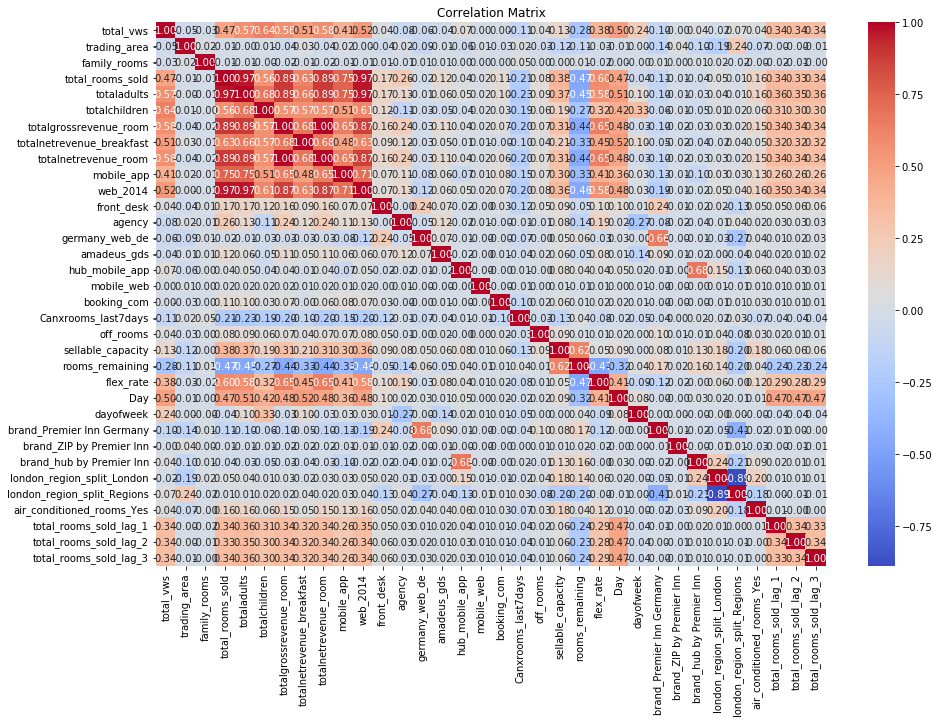

In [99]:
# Create a correlation matrix for the selected numeric features

# Select numeric features
numeric_features = list(data.select_dtypes(include=[np.number]).columns)

correlation_matrix = data[numeric_features].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [100]:
# Removing the duplicate column
data = data.drop(['total_rooms_sold_lag_1', 'total_rooms_sold_lag_2'],axis=1)

In [101]:
# Select numeric features for outlier detection
numeric_features = list(data.select_dtypes(include=[np.number]).columns)

correlation_matrix_numerical = data[numeric_features].corr()

# Filter the correlation matrix to include only numerical features exclude the target feature
numeric_features.remove('total_rooms_sold')

# Set the threshold for high correlation (0.8 or -0.8)
threshold = 0.8

# Create a list to store pairs of highly correlated features
highly_correlated_features,features_variance = [],[]

# Iterate through the correlation matrix and find highly correlated features
for i in range(len(correlation_matrix_numerical.columns)):
    for j in range(i + 1, len(correlation_matrix_numerical.columns)):
        if abs(correlation_matrix_numerical.iloc[i, j]) > threshold:
            feature_i = correlation_matrix_numerical.columns[i]
            feature_j = correlation_matrix_numerical.columns[j]
            correlation_value = correlation_matrix_numerical.iloc[i, j]
            highly_correlated_features.append((feature_i, feature_j, correlation_value))

            """
            To decide which feature to keep, you can compare the variance of
            each feature and choose the one with the higher variance:
            """

            var_feature_i = data[feature_i].var()
            var_feature_j = data[feature_j].var()
            features_variance.append((feature_i, feature_j, var_feature_i, var_feature_j))


# Display the highly correlated feature pairs and their correlation values
print("multicollinearity:")
for feature_i, feature_j, correlation_value in highly_correlated_features:
    print(f"{feature_i} and {feature_j} have a correlation of {correlation_value:.3f}")


multicollinearity:
total_rooms_sold and totaladults have a correlation of 0.967
total_rooms_sold and totalgrossrevenue_room have a correlation of 0.890
total_rooms_sold and totalnetrevenue_room have a correlation of 0.890
total_rooms_sold and web_2014 have a correlation of 0.970
totaladults and totalgrossrevenue_room have a correlation of 0.889
totaladults and totalnetrevenue_room have a correlation of 0.889
totaladults and web_2014 have a correlation of 0.970
totalgrossrevenue_room and totalnetrevenue_room have a correlation of 1.000
totalgrossrevenue_room and web_2014 have a correlation of 0.867
totalnetrevenue_room and web_2014 have a correlation of 0.868
london_region_split_London and london_region_split_Regions have a correlation of -0.889


In [102]:
# Display the feature pairs and their variance values
print("\n Variance:")
for feature_i, feature_j, var_feature_i, var_feature_j in features_variance:
    print(f"\nVariance of {feature_i}", var_feature_i)
    print(f"Variance of {feature_j}", var_feature_j)

    try:
        if var_feature_i > var_feature_j:
            data = data.drop(feature_j, axis=1)
        else:
            data = data.drop(feature_i, axis=1)
    except KeyError as err:
        pass

print(f"\nSelected features", data.columns)


 Variance:

Variance of total_rooms_sold 951.8922340211034
Variance of totaladults 2572.7482053864765

Variance of total_rooms_sold 951.8922340211034
Variance of totalgrossrevenue_room 3515644.905054847

Variance of total_rooms_sold 951.8922340211034
Variance of totalnetrevenue_room 3188217.2002452193

Variance of total_rooms_sold 951.8922340211034
Variance of web_2014 684.6815515262351

Variance of totaladults 2572.7482053864765
Variance of totalgrossrevenue_room 3515644.905054847

Variance of totaladults 2572.7482053864765
Variance of totalnetrevenue_room 3188217.2002452193

Variance of totaladults 2572.7482053864765
Variance of web_2014 684.6815515262351

Variance of totalgrossrevenue_room 3515644.905054847
Variance of totalnetrevenue_room 3188217.2002452193

Variance of totalgrossrevenue_room 3515644.905054847
Variance of web_2014 684.6815515262351

Variance of totalnetrevenue_room 3188217.2002452193
Variance of web_2014 684.6815515262351

Variance of london_region_split_London 0.

In [103]:
# Check summary statistics of each DataFrame
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
          total_vws  trading_area  family_rooms  totalchildren  \
count  24645.000000  24645.000000  2.464500e+04   24645.000000   
mean     430.051532     17.923595 -5.226575e+06       6.340434   
std      598.143586     10.225138  1.058005e+08      13.552904   
min        1.000000      0.000000 -2.146826e+09       0.000000   
25%      122.000000     10.000000  1.200000e+01       0.000000   
50%      230.000000     18.000000  2.200000e+01       2.000000   
75%      471.000000     28.000000  3.400000e+01       5.000000   
max     7312.000000     33.000000  3.330000e+02     209.000000   

       totalgrossrevenue_room  totalnetrevenue_breakfast    mobile_app  \
count            24645.000000               24645.000000  24645.000000   
mean              2012.683881                  29.305726      3.372205   
std               1875.005308                  50.270277      3.712396   
min                  0.000000                   0.000000      0.000000   
25%           

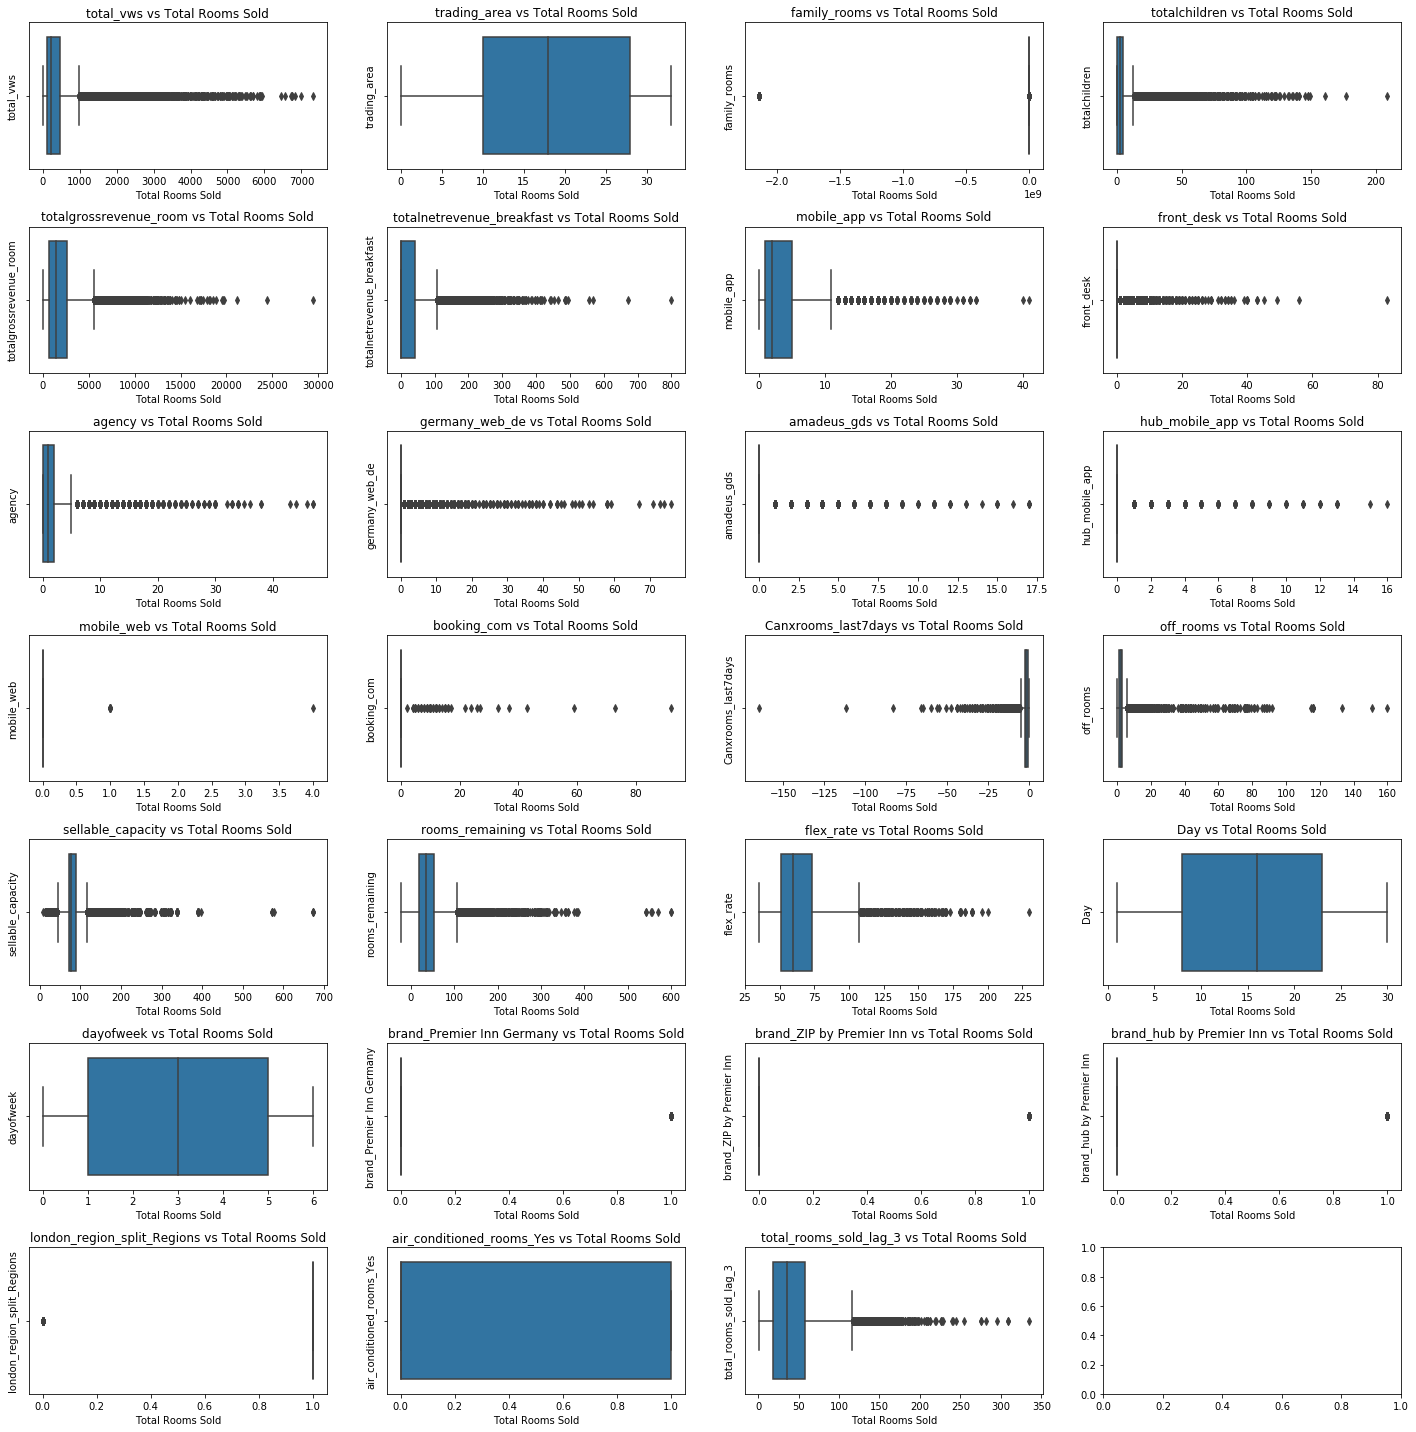

In [104]:
# Outlier Detection in Data
# Create subplots for box plots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

numeric_features = list(data.select_dtypes(include=[np.number]).columns)

# Create box plots for each feature
for i, feature in enumerate(numeric_features):
    sns.boxplot(x=feature,data=data, ax=axes[i])
    axes[i].set_title(f"{feature} vs Total Rooms Sold")
    axes[i].set_xlabel("Total Rooms Sold")
    axes[i].set_ylabel(feature)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [105]:
# Handling Outliers using Z-Score 

for feature in numeric_features:
    # Calculate the Z-Score for 'Total digital visits' column
    data['z_score'] = (data[feature] - data[feature].mean()) / data[feature].std()

    # Define the threshold for outliers (Z-Score of 3 or higher)
    threshold = 3

    # Replace outlier values with the mean value
    data[feature] = data[feature].where(data['z_score'].abs() < threshold, data[feature].mean())

    # Drop the Z-Score column if it's not needed anymore
    data.drop('z_score', axis=1, inplace=True)

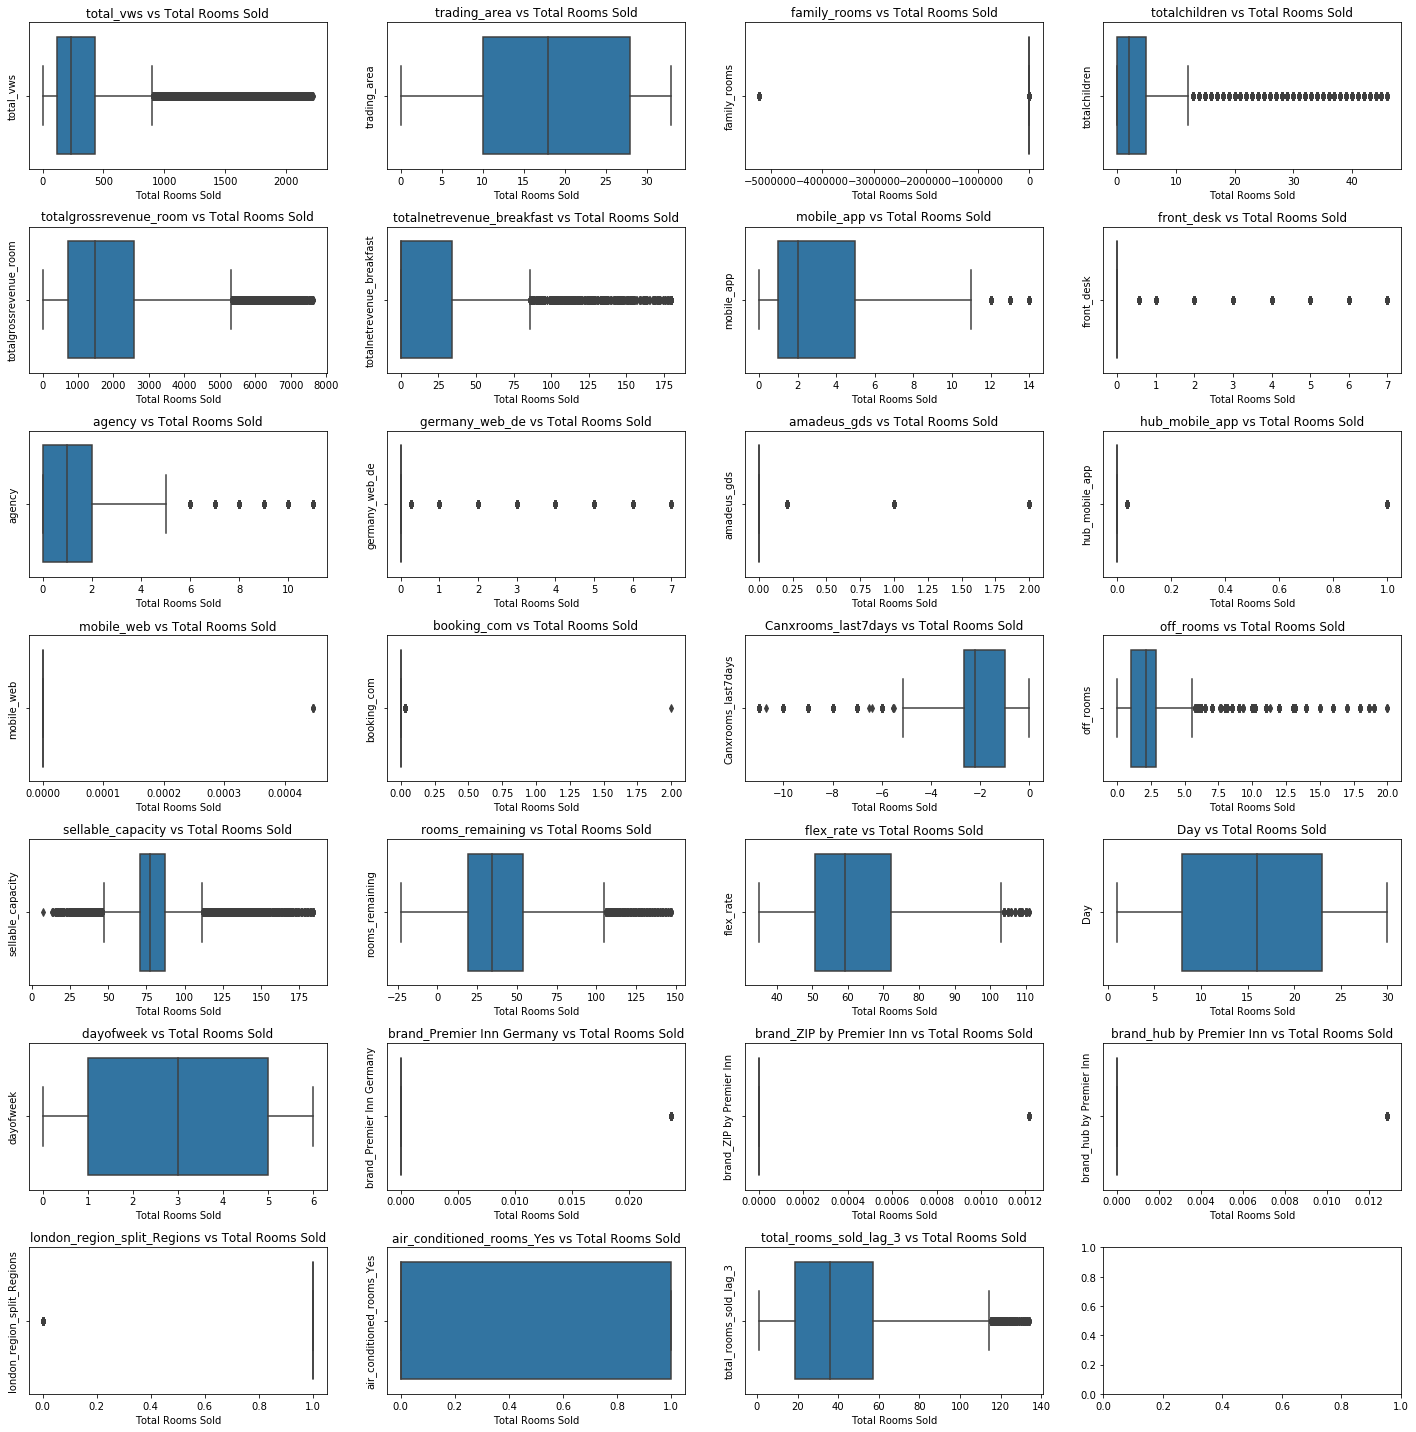

In [110]:
# Create subplots for box plots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

numeric_features = list(data.select_dtypes(include=[np.number]).columns)

# Create box plots for each feature
for i, feature in enumerate(numeric_features):
    sns.boxplot(x=feature,data=data, ax=axes[i])
    axes[i].set_title(f"{feature} vs Total Rooms Sold")
    axes[i].set_xlabel("Total Rooms Sold")
    axes[i].set_ylabel(feature)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [107]:
len(data.columns)

27

# Train Test Split

In [108]:
X = data.drop(['total_rooms_sold_lag_3'],axis=1)
y= data['total_rooms_sold_lag_3']

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Building

In [111]:
Result = []

# Create the multiple linear regression model
linear_reg_model = LinearRegression()

# Perform cross-validation on the training set
cv_scores = cross_val_score(linear_reg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Since cross_val_score returns negative mean squared error, take the absolute value
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)

print("Cross-Validation RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Standard Deviation of RMSE:", np.std(rmse_scores))

# Train the multiple linear regression model on the entire training set
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_reg_model.predict(X_test)

# Evaluate the model on the test set
# Calculate the Mean Squared Error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('\nMean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)
print('Root Mean Squared Error:', RMSE)

Result.append(["LinearRegression",MAE,MSE,RMSE])

Cross-Validation RMSE scores: [23.08837877 23.66466071 23.61743733 23.02070135 23.6963982 ]
Mean RMSE: 23.41751527199834
Standard Deviation of RMSE: 0.2982004396326018

Mean Absolute Error: 18.270133213567224
Mean Squared Error: 563.2642143065473
Root Mean Squared Error: 23.73318803503961


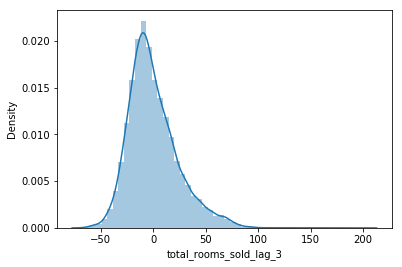

In [112]:
sns.distplot(y_test-y_pred)

In [113]:
# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'alpha': np.logspace(-4, 2, 100),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Create the Ridge regression model
ridge_model = Ridge()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=ridge_model, param_distributions=param_grid, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)

# Fit the model to find the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters found by RandomizedSearchCV
best_alpha = random_search.best_params_['alpha']
best_solver = random_search.best_params_['solver']

print(random_search.best_params_)

# Train the Ridge regression model with the best hyperparameters
ridge_model_best = Ridge(alpha=best_alpha, solver=best_solver)
ridge_model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model_best.predict(X_test)

# Calculate the Mean Squared Error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('\nMean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)
print('Root Mean Squared Error:', RMSE)

Result.append(["RidgeRegression",MAE,MSE,RMSE])

C:\Users\anjal\.conda\envs\virn\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


{'solver': 'svd', 'alpha': 0.00572236765935022}

Mean Absolute Error: 18.26877509357772
Mean Squared Error: 562.2276072230339
Root Mean Squared Error: 23.711339211926305


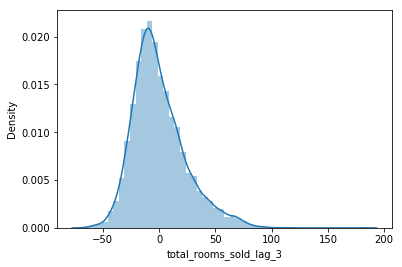

In [114]:
sns.distplot(y_test-y_pred)


Mean Absolute Error: 18.249323112771823
Mean Squared Error: 557.6468299946089
Root Mean Squared Error: 23.614546999563824


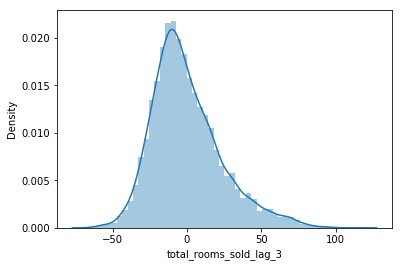

In [115]:
# Create the Lasso regression model
lasso_model = Lasso()

# Define the hyperparameter grid for tuning
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Values for the regularization strength
}

# Perform grid search with 5-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Create the Lasso regression model with the best hyperparameters
best_lasso_model = Lasso(alpha=best_alpha)

# Train the Lasso regression model on the entire training set
best_lasso_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_lasso_model.predict(X_test)

# Evaluate the model on the test set
# Calculate the Mean Squared Error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('\nMean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)
print('Root Mean Squared Error:', RMSE)

Result.append(["LassoRegression",MAE,MSE,RMSE])

sns.distplot(y_test-y_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   54.1s finished


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

Mean Absolute Error: 17.089316121252384
Mean Squared Error: 506.8876030028604
Root Mean Squared Error: 22.51416449710849


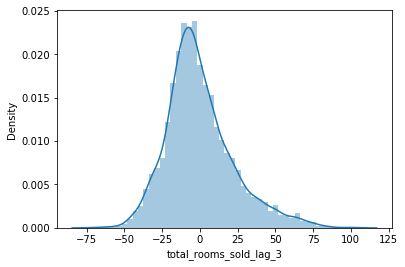

In [116]:
# Define the hyperparameter grid for random search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5]
}

# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Perform Randomized Search Cross-Validation
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10,\
                                   scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
xgb_model_best = xgb.XGBRegressor(**best_params)
xgb_model_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model_best.predict(X_test)

# Evaluate the model
# Calculate the Mean Squared Error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('\nMean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)
print('Root Mean Squared Error:', RMSE)

Result.append(["XGBRegressor",MAE,MSE,RMSE])

sns.distplot(y_test-y_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1943
[LightGBM] [Info] Number of data points in the train set: 11500, number of used features: 24
[LightGBM] [Info] Start training from score 40.741587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
  File "C:\Users\anjal\.conda\envs\virn\lib\site-packages\joblib\externals\loky\backend\context.py", line 229, in _count_physical_cores
    capture_output=True)
  File "C:\Users\anjal\.conda\envs\virn\lib\subprocess.py", line 423, in run
    with Popen(*popenargs, **kwargs) as process:


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1943
[LightGBM] [Info] Number of data points in the train set: 11500, number of used features: 24
[LightGBM] [Info] Start training from score 40.741587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1943
[LightGBM] [Info] Number of data points in the train set: 11500, number of used features: 24
[LightGBM] [Info] Start training from score 40.741587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 11501, number of used features: 24
[LightGBM] [Info] Start training from score 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.2s finished


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

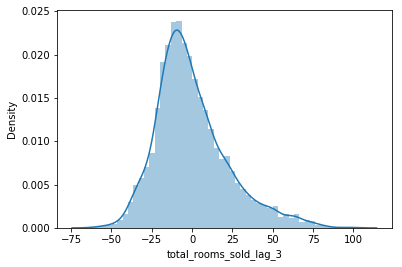

In [117]:
# Define the LightGBM model
lgb_model = lgb.LGBMRegressor()

# Define the hyperparameter grid for random search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Perform Randomized Search Cross-Validation
random_search = RandomizedSearchCV(lgb_model, param_distributions=param_grid, n_iter=10,\
                                   scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
lgb_model_best = lgb.LGBMRegressor(**best_params)
lgb_model_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lgb_model_best.predict(X_test)

# Evaluate the model
# Calculate the Mean Squared Error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('\nMean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)
print('Root Mean Squared Error:', RMSE)

Result.append(["LGBMRegressor",MAE,MSE,RMSE])

sns.distplot(y_test-y_pred)

# Model Evaluation

In [118]:
df_results = pd.DataFrame(Result, columns=['Model Name', 'Mean Absolute Error','Mean Squared Error','Root Mean Squared Error']).sort_values(by=["Root Mean Squared Error"],ascending=False)
df_results

,Model Name,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,LinearRegression,18.270133,563.264214,23.733188
1,RidgeRegression,18.268775,562.227607,23.711339
2,LassoRegression,18.249323,557.646830,23.614547
4,LGBMRegressor,17.271786,508.651585,22.553305
3,XGBRegressor,17.089316,506.887603,22.514164


In [119]:
import pickle
# Creating a pickle file for the classifier
filename = 'hotel-occupancy-prediction-model.pkl'
pickle.dump(xgb_model_best, open(filename, 'wb'))